# Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime
from multiprocessing import Pool

In [2]:
from array import array
import numpy as np
import root_numpy as rtnp
import scipy.stats as sps
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
from progressBar import ProgressBar

Welcome to JupyROOT 6.12/07


In [3]:
import uproot as ur
import ROOT as rt
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH2D, create_TH1D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from gridVarQ2Plot import col_dic, label_dic

rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis, Handle, Events

webDir = '/storage/user/ocerri/public_html/BPH_RDst/pythiaProcessesComparison/'

In [74]:
def make_comp_plot_1D(inputs, #[x, label, color=-1 (auto), ]
                      transformX = None,
                      binning=[None, None, None],
                      setLog = '',
                      miny = 0,
                      axis_title = ['', ''],
                      scale_histo = 'norm',
                      opt='overflow+underflow',
                      leg_loc=[0.6, 0.7, 0.9, 0.93], # x0, y0, w, h
                      tag='',
                      ratioPlots = False,
                      weights = [],
                      hTags = [],
                      showError=True,
                     ): 
    
    if weights == []:
        weights = [None]*len(inputs)
        
    if hTags == []:
        hTags = ['h'+str(i) for i in range(len(inputs))]
    
    if not leg_loc is None:
        leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[0] + leg_loc[2], leg_loc[1] + leg_loc[3])
        leg.SetBorderSize(0)
        leg.SetFillStyle(0)
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hList = []
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        if isinstance(scale_histo, list):
            auxScale = scale_histo[i]
        else:
            auxScale = scale_histo
        h = create_TH1D(x, name=hTags[i], title=hTags[i],
                        binning=binning if i==0 else hList[0].binning, 
                        axis_title=axis_title,
                        scale_histo=auxScale, 
                        widthNorm=True,
                        opt=opt,
                        weights=weights[i]
                       )
        if not showError:
            h.Sumw2(0)
        h.SetLineColor(colors[i])
        if not leg_loc is None:
            leg.AddEntry(h, label, 'lp')
        hList.append(h)
            
    m = SetMaxToMaxHist(hList)
    hList[0].GetYaxis().SetRangeUser(miny, m)
    if ratioPlots:
        c = make_ratio_plot(hList, leg_pos=None, 
                            label=tag, 
                            draw_opt='E1' if showError else '',
                            ratio_bounds='auto')
        c.Draw()
        c.cd(1)
        pad = c.pad1
        CMS_lumi.CMS_lumi(pad, -1, 0)
    else:
        c = drawOnCMSCanvas(CMS_lumi, hList, 'same', tag=tag)
        pad = c
        
    leg.Draw()
    
    if 'x' in setLog: pad.SetLogx()
    if 'y' in setLog: pad.SetLogy()
    
    c.dnd = [hList, leg]
    return c

In [5]:
ds = {}
ds['mu_HardQCD'] = DSetLoader('B0_MuNuDmst_PUc0')
ds['mu_SoftQCD'] = DSetLoader('B0_MuNuDmst_SoftQCDall_PUc0')

In [6]:
txt = rt.TLatex()
txt.SetTextAlign(12)
txt.SetTextSize(0.04)
txt.SetTextFont(42)

# Inputs

In [ ]:
base = '/mnt/hadoop/store/user/ocerri/cmsMC_private_PUc0_10-2-3/'
loc = {}

loc['mu_HardQCD'] = base + 'BP_Tag_B0_MuNuDmst_Hardbbbar*/*/*/out_MINIAODSIM_*.root'
loc['mu_SoftQCD'] = base + 'BP_Tag_B0_MuNuDmst_SoftQCDall*/*/*/out_MINIAODSIM_*.root'

In [ ]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'SIM')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'SIM')]

In [ ]:
eff = {}
nMax = 100
for n, ftempl in loc.iteritems():
    print n
    N_cuts = 0
    N_gen = 0
    flist = glob(ftempl)
    if len(flist) > nMax:
        flist = np.random.choice(flist, nMax)
    for fn in flist:
        for lumi in Lumis(fn):
            prods = {}
            for k,v in handle.iteritems():
                lumi.getByLabel(v[1], v[0])
                prods[k] = v[0].product()
            N_cuts += prods['genFilter'].numEventsPassed()
            N_gen += prods['genFilter'].numEventsTotal()
           
    e, de = getEff(N_cuts, N_gen)
    eff[n] = [e, de]
    print 'eff generator: {:1.2e} +/- {:1.2e} ({:1.1e})'.format(e, de, de/e)
    print '\n'

# Extract informations from edm

In [ ]:
def extractFromFile(inputs):
    iJob = inputs[0]
    fn = inputs[1]
    nMax = inputs[2]
    
    events = Events(fn)
    nTot = events.size()
    nOut = float(min(nTot, nMax))
    outDs = np.zeros((int(nOut), 4))
    for iEv, event in enumerate(events):
        if iEv ==0 or (iEv+1) % int(nOut/2.0) == 0:
            pass
#             print '{}: {:.0f} %'.format(iJob, 100.*(iEv+1)/nOut)

        handle = Handle('vector<reco::GenParticle>')
        event.getByLabel(('prunedGenParticles', '', 'PAT'), handle)

        ptB = []
        etaB = []
        pt = []
        eta = []
        for p in handle.product():
            if not p.pdgId() == 511:
                continue
            ptB.append(p.pt())
            etaB.append(p.eta())
            for d in p.daughterRefVector():
                if d.pdgId() == -13:
                    pt.append(d.pt())
                    eta.append(d.eta())
                elif d.pdgId() == -15:
                    for dd in d.daughterRefVector():
                        if dd.pdgId() == -13:
                            pt.append(dd.pt())
                            eta.append(dd.eta())
        if len(pt) < 2:
            idx = 0
        else:
            pt = np.array(pt)
            eta = np.array(eta)
            sel = np.logical_and(pt > 6.7, np.abs(eta) < 1.6)

            if np.sum(sel) > 0:
                idx = np.random.choice(np.nonzero(sel)[0])
            else:
                idx = np.random.choice(pt.shape[0])
        outDs[iEv, 0] = pt[idx]
        outDs[iEv, 1] = eta[idx]
        outDs[iEv, 2] = ptB[idx]
        outDs[iEv, 3] = etaB[idx]

        if iEv == nMax - 1:
            break
    print 'Job {} done ({} events)'.format(iJob, iEv)
    return [outDs, iEv+1]

In [ ]:
nMax = 1e9
nFileMax = {'mu_SoftQCD': 5000, 'mu_HardQCD':100}
dset = {}
nTot = {}
recreate = []#['mu_SoftQCD', 'mu_HardQCD']

for n, ftempl in loc.iteritems():
    print n
    
    idx = ftempl.find('10-2-3') + len('10-2-3')
    outname = ds[n].candLoc + ds[n].full_name+'/miniaodGenInfo.pkl'
    if os.path.exists(outname) and not n in recreate:
        print 'Loading file'
        nTot[n], outDs = pickle.load( open(outname, 'rb') )
    else:
        inputs = []
        
        for i, fn in enumerate(glob(ftempl)):
            inputs.append([str(i), fn, nMax])
            if i == nFileMax[n]-1:
                break
            
        p = Pool(min(20,len(inputs)))
        outputs = p.map(extractFromFile, inputs)
        print 'Concatenating outpusts'
        outDs = np.concatenate(tuple([o[0] for o in outputs]))
        nTot[n] = np.sum([o[1] for o in outputs])
        
        pickle.dump( [nTot[n], outDs], open( outname, 'wb' ) )
    dset[n] = outDs
    print 'Tot candidates: '+ str(outDs.shape[0])
    print 'Done\n\n'

# Analyze gen data

In [ ]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [ ]:
# make_comp_plot_1D(
#     [
#         [dset['mu'][:,0], label_dic['mu']],
#         [dset['tau'][:,0], label_dic['tau']],
#     ],
#     binning=np.logspace(-2, 2, 70), setLog='xy', miny=1e-5,
#     axis_title = ['Muon p_{T} [GeV]', 'Normalized events'],
#     leg_loc=[0.2, 0.75, 0.2, 0.15]
# )


In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,0], 'HardQCD'],
        [dset['mu_SoftQCD'][:,0], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 20, 70), setLog='', miny=1e-5,
    axis_title = ['Gen muon p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [np.abs(dset['mu_HardQCD'][:,1]), 'HardQCD'],
        [np.abs(dset['mu_SoftQCD'][:,1]), 'SoftQCD'],
    ],
    binning=np.linspace(0, 1.6, 70), setLog='y', miny=1e-5,
    axis_title = ['Gen muon #eta', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,2], 'HardQCD'],
        [dset['mu_SoftQCD'][:,2], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 50, 50), setLog='', miny=1e-5,
    axis_title = ['Gen B p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.6, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,3], 'HardQCD'],
        [dset['mu_SoftQCD'][:,3], 'SoftQCD'],
    ],
    binning=np.linspace(-2, 2, 50), setLog='', miny=1e-5,
    axis_title = ['B #eta', 'Normalized events'],
    leg_loc=[0.8, 0.8, 0.2, 0.15]
)

# Analyze reco data

## Load the skimmed data frames

In [137]:
np.linspace(0.3, 1.93, 23)

array([0.3       , 0.37409091, 0.44818182, 0.52227273, 0.59636364,
       0.67045455, 0.74454545, 0.81863636, 0.89272727, 0.96681818,
       1.04090909, 1.115     , 1.18909091, 1.26318182, 1.33727273,
       1.41136364, 1.48545455, 1.55954545, 1.63363636, 1.70772727,
       1.78181818, 1.85590909, 1.93      ])

In [139]:
binning = {'q2': array('d', [0, 3.5, 6, 9.4, 12])}
binning['M2_miss'] = [
        array('d', [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4] ),
        array('d', [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8] ),
        array('d', list(np.arange(0, 6, 0.2)) + [8] ),
        array('d', list(np.arange(0, 7.8, 0.2)) + [8] ),
    ]
binning['Est_mu'] = [
        array('d', [0.3] + list(np.arange(0.5, 2.25, 0.05)) + [2.3] ),
        array('d', [0.3] + list(np.arange(0.5, 2.2, 0.05)) + [2.2] ),
        array('d', [0.3] + list(np.arange(0.5, 2.1, 0.05)) + [2.1] ),
        array('d', list(np.linspace(0.3, 1.93, 23)))
    ]

xAx_title = {'M2_miss':'m^{2}_{miss} [GeV^{2}]', 'Est_mu':'E_{#mu}* [GeV]'}

In [114]:
category = 'Low'

In [115]:
dsHard = pd.DataFrame(rtnp.root2array(ds['mu_HardQCD'].skimmed_dir + '/{}_bare.root'.format(category)))
dsSoft = pd.DataFrame(rtnp.root2array(ds['mu_SoftQCD'].skimmed_dir + '/{}_bare.root'.format(category)))

## Compute corrections (one shot)

In [116]:
class pythiaCalOneShotReader:
    def __init__(self, calibration_file=None):
        if not calibration_file is None:
            self.loadCalibration(calibration_file)
            
    def loadCalibration(self, calibration_file):
        d = pickle.load(open( calibration_file, 'rb' ))
        self.beta = d['beta']
        self.betaVar = d['betaVar']
        self.nVar = len(d['betaVar'])
        self.x = None
            
    def loadInputs(self, ds):
        x = np.array(ds[['q2','M2_miss', 'Est_mu']])
        x = np.column_stack((
            np.ones_like(x[:,0]),
            x,
            x[:,0]*x[:,1],
            x[:,0]*x[:,2],
            x[:,1]*x[:,2],
        ))
        
        self.x = x
        
    def _computeWeights(self, beta, pMin=1e-2):
        p = np.clip(np.dot(self.x, beta), pMin, 1-pMin)
        w = p/(1-p)
        return w

    def getWeights(self, shape=0, scale=1.):

        sign = np.sign(shape)
        idx = np.abs(shape) - 1
        delta_p = sign*scale*self.betaVar[idx]
        
        return self._computeWeights(self.beta + delta_p)

In [117]:
def prepareInputs(ds):
    aux = pythiaCalOneShotReader()
    aux.loadInputs(ds)
    return aux.x

xS = prepareInputs(dsSoft)
xH = prepareInputs(dsHard)
rSH = dsSoft.shape[0]/float(dsHard.shape[0])
    

def loss(beta, pMin=1e-2):
    pS = np.clip(np.dot(xS, beta), pMin, 1-pMin)
    #class y = 1
    
    pH = np.clip(np.dot(xH, beta), pMin, 1-pMin)
    #calss y = 0
    
    #NLL = - sum(y * ln(p)) - sum((1-y)*ln(1-p))
    NLL =  - np.sum(np.log(pS)) - np.sum(np.log(1-pH)) * rSH
    return NLL

In [118]:
from scipy.optimize import minimize

beta0 = np.array([0.5] + [0.]*(xS.shape[1]-1))

print 'Start NLL: {:.1f}'.format(loss(beta0))
res = minimize(loss, beta0, tol=1e-6)
print 'End NLL: {:.1f}'.format(res.fun)

Start NLL: 21846.6
End NLL: 21843.7


In [119]:
beta = res.x
covBeta = res.hess_inv

eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('../data/calibration/pythiaProcessesHardToSoft/polyOneShot'+category+'.pkl', 'wb'))

Beta:  4.90e-01, 4.53e-03, -9.40e-03, 9.28e-03, 1.71e-03, -2.38e-03, -8.69e-03
Error: 5.40e-02, 1.77e-02, 3.03e-02, 2.55e-02, 2.18e-03, 9.41e-03, 2.83e-02


eigSigma: 7.45e-02
eigVect: -0.72, 0.23, -0.40, 0.34, -0.02, -0.12, 0.37
Variation: -5.37e-02, 1.73e-02, -2.98e-02, 2.53e-02, -1.83e-03, -9.15e-03, 2.75e-02


eigSigma: 8.28e-03
eigVect: -0.58, 0.04, 0.51, 0.04, 0.01, 0.05, -0.63
Variation: -4.83e-03, 3.24e-04, 4.23e-03, 3.03e-04, 9.64e-05, 4.32e-04, -5.19e-03


eigSigma: 6.66e-03
eigVect: 0.25, 0.11, -0.50, 0.51, 0.14, -0.14, -0.61
Variation: 1.70e-03, 7.20e-04, -3.31e-03, 3.39e-03, 9.34e-04, -9.53e-04, -4.10e-03


eigSigma: 4.53e-03
eigVect: -0.13, -0.84, -0.10, 0.28, 0.13, 0.42, 0.04
Variation: -6.08e-04, -3.80e-03, -4.54e-04, 1.28e-03, 5.95e-04, 1.88e-03, 2.01e-04


eigSigma: 5.83e-04
eigVect: -0.04, 0.18, -0.32, -0.21, -0.62, 0.63, -0.19
Variation: -2.43e-05, 1.04e-04, -1.89e-04, -1.22e-04, -3.64e-04, 3.66e-04, -1.08e-04


eigSigma: 1.02e-04
eigVect: 0.24, 0.26, 0.46, 0.70, -0

In [120]:
calReader = pythiaCalOneShotReader('../data/calibration/pythiaProcessesHardToSoft/polyOneShot'+category+'.pkl')
calReader.loadInputs(dsHard)

weights = calReader.getWeights()

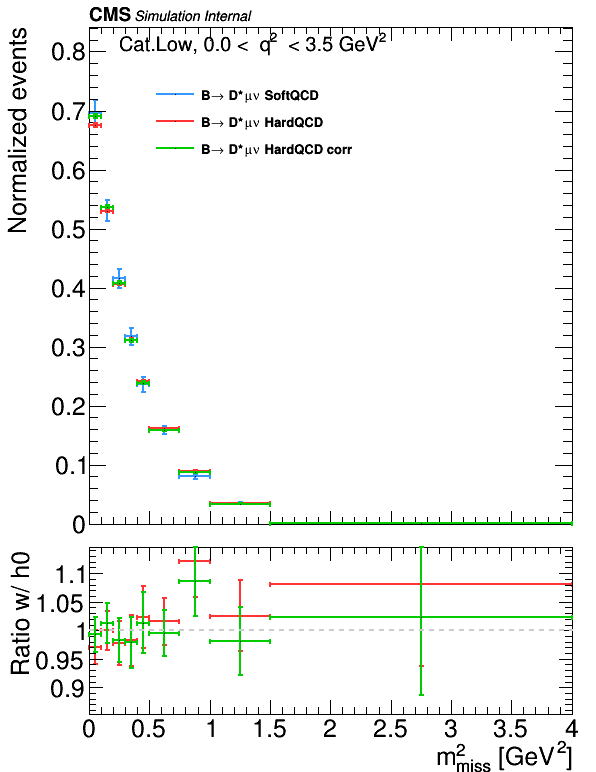

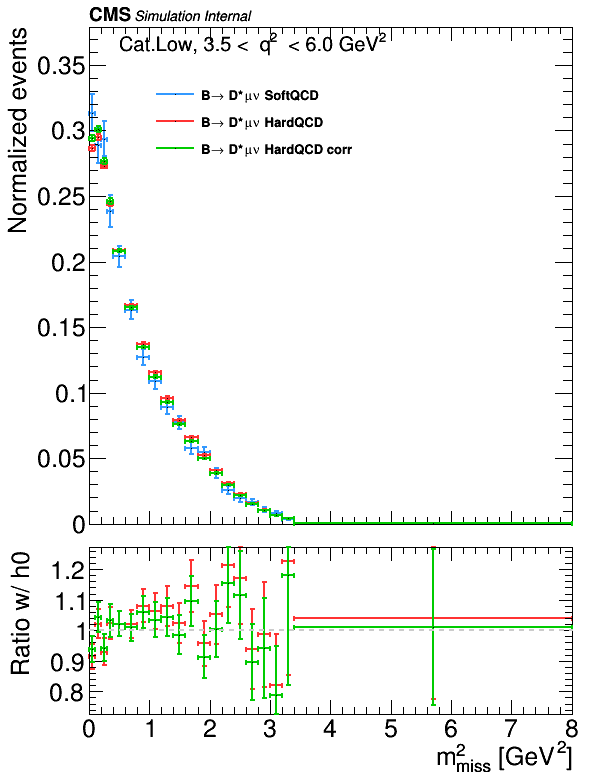

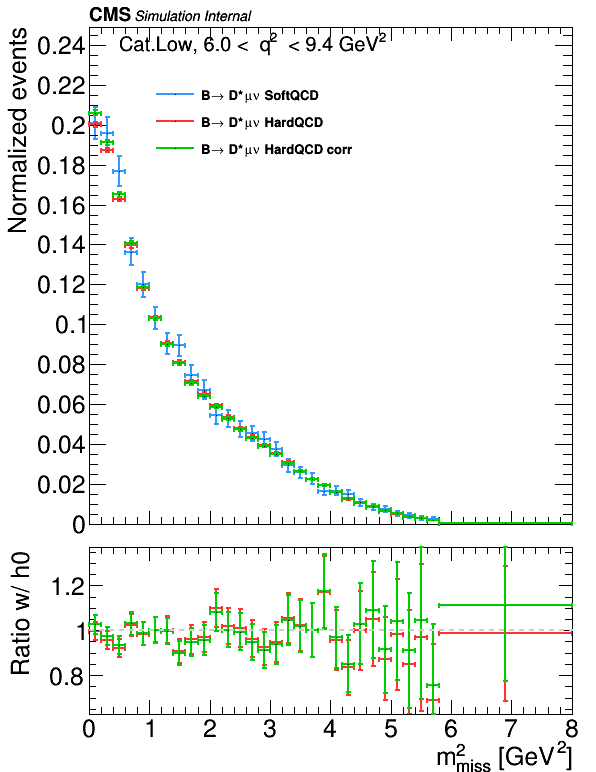

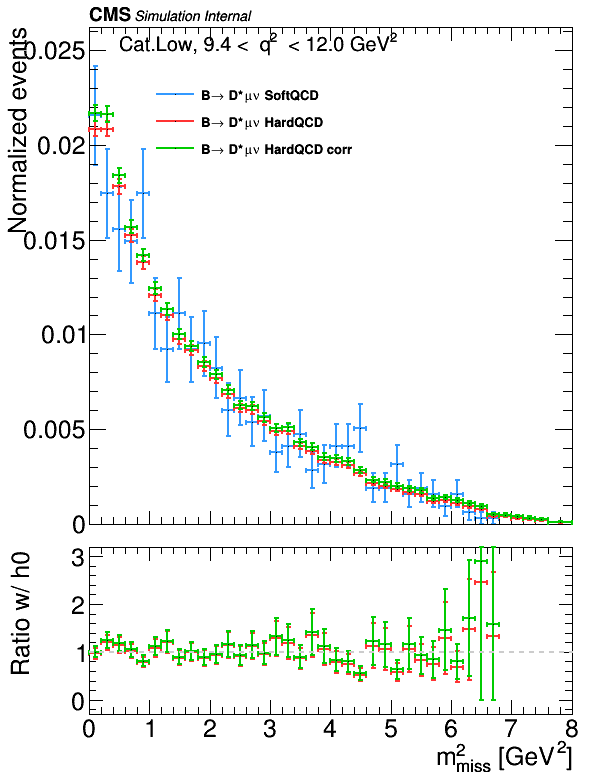

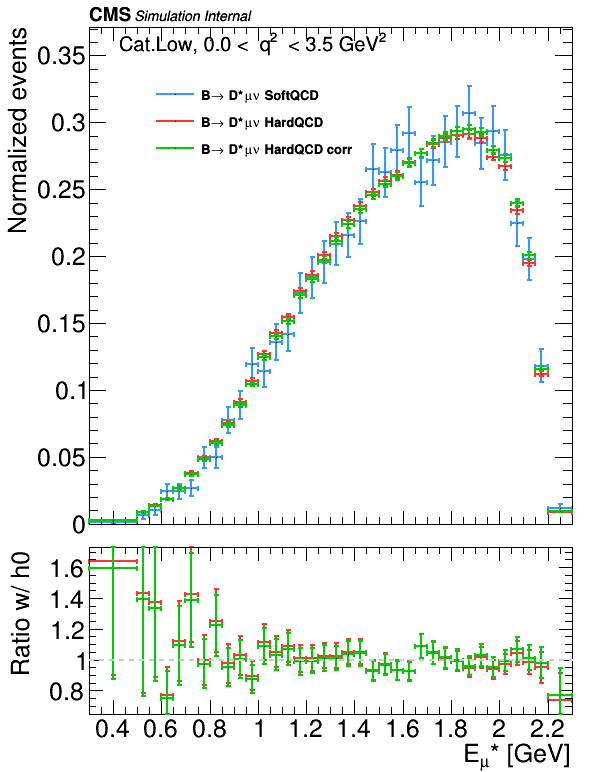

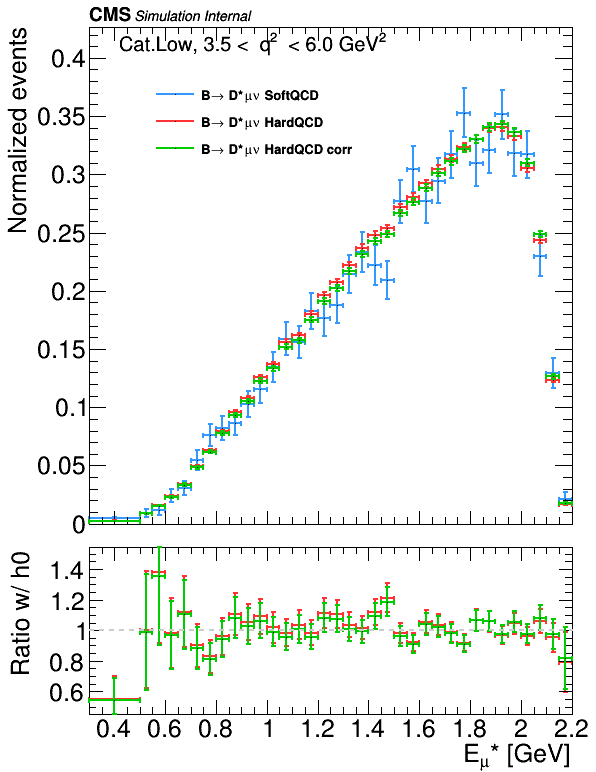

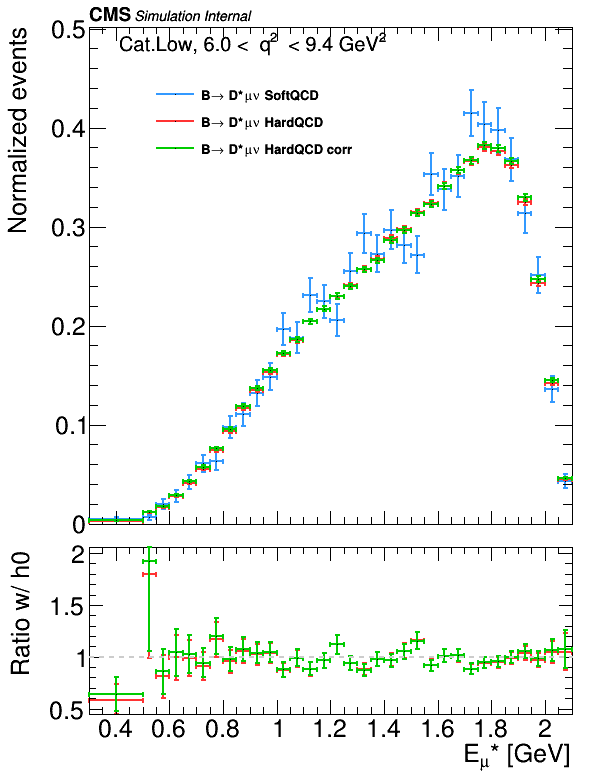

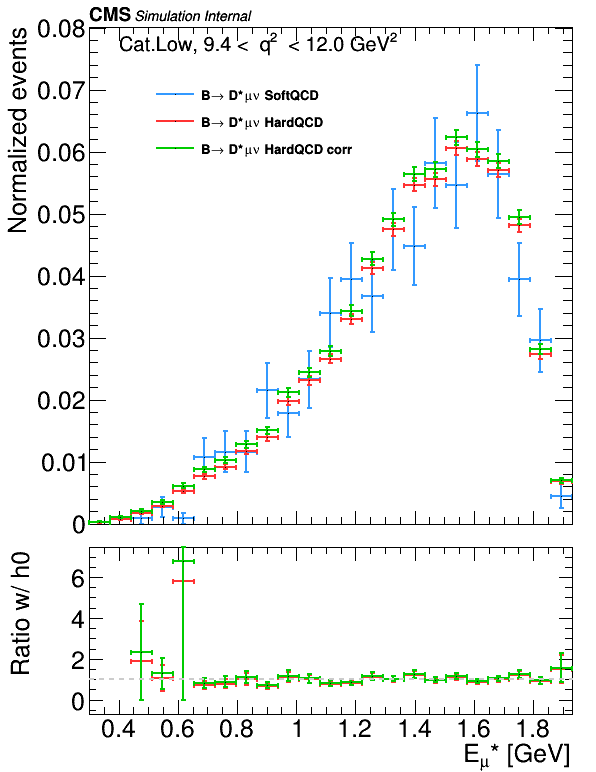

In [121]:
canvasOut = []
for var in ['M2_miss', 'Est_mu']:
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)
        selSoft = np.logical_and(dsSoft['q2'] > q2_l, dsSoft['q2'] <= q2_h)
        selHard = np.logical_and(dsHard['q2'] > q2_l, dsHard['q2'] <= q2_h)

        c = make_comp_plot_1D(
            [
                [dsSoft[var][selSoft], 'B#rightarrow D*#mu#nu SoftQCD'],
                [dsHard[var][selHard], 'B#rightarrow D*#mu#nu HardQCD'],
                [dsHard[var][selHard], 'B#rightarrow D*#mu#nu HardQCD corr'],
            ],
            weights=[None, None, weights[selHard]],
            scale_histo = [1./selSoft.shape[0], 1./selHard.shape[0], 1./selHard.shape[0]],
            binning=binning[var][i_q2], 
            setLog='', miny=1e-6,
            axis_title = [xAx_title.get(var, var), 'Normalized events'],
            leg_loc=[0.25, 0.7, 0.35, 0.15],
            tag=category +'_'+ var+'_q2bin'+str(i_q2),
            ratioPlots=True
        )
        txt.DrawLatexNDC(0.2, 0.92, 'Cat.' + category.capitalize() + ', ' + q2_txt)
        
        c.SaveAs(webDir + category + 'oneShot0_' + var + '_q2bin'+str(i_q2) + '.png')
        canvasOut.append(c)

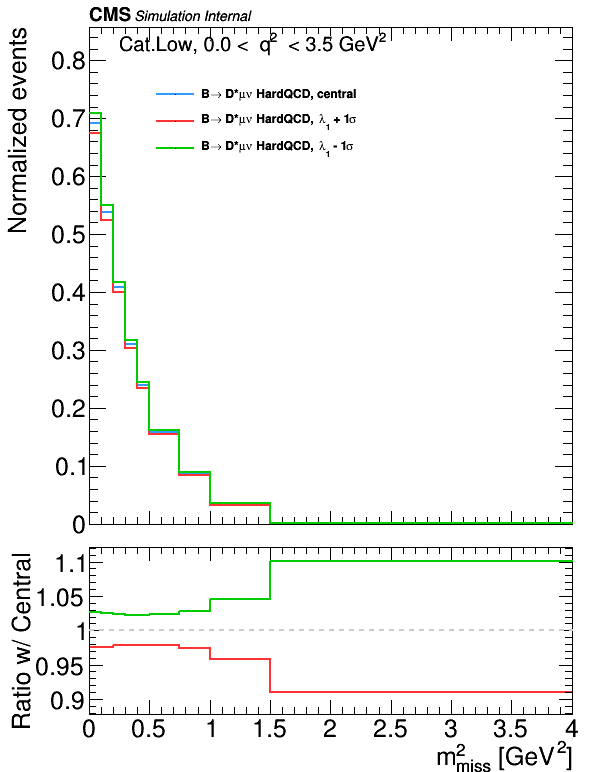

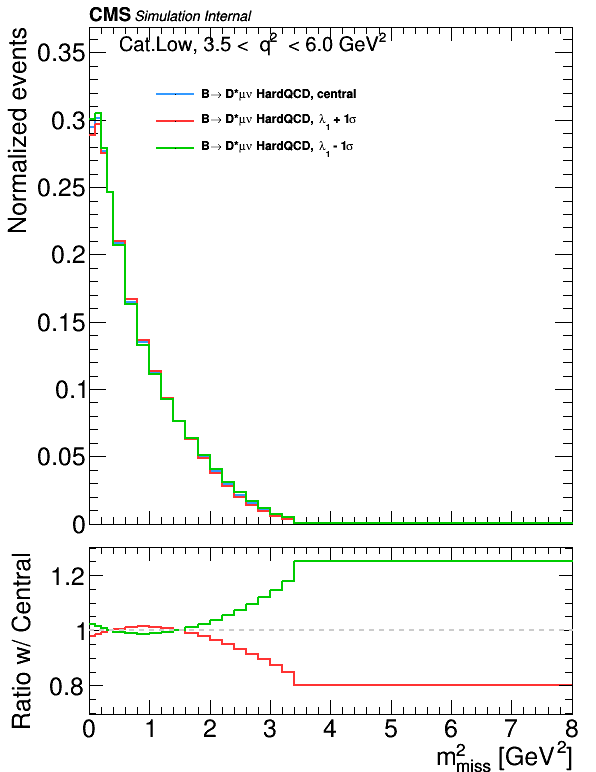

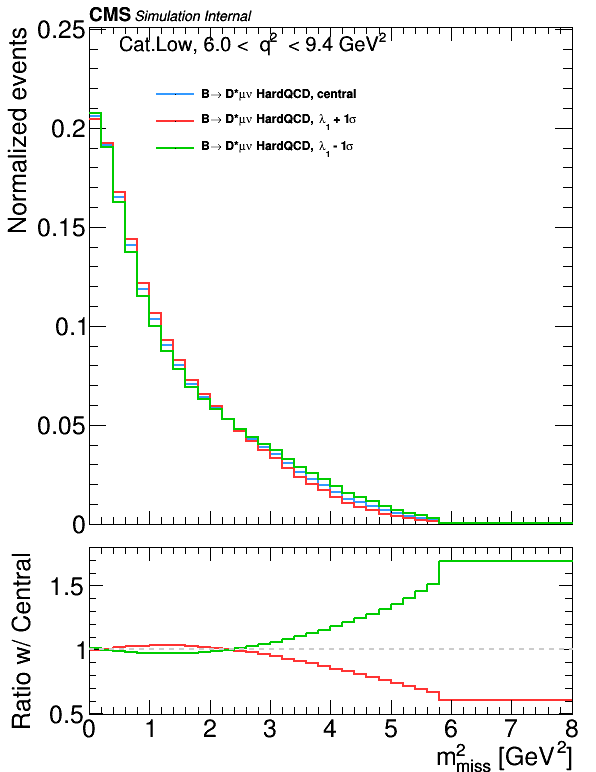

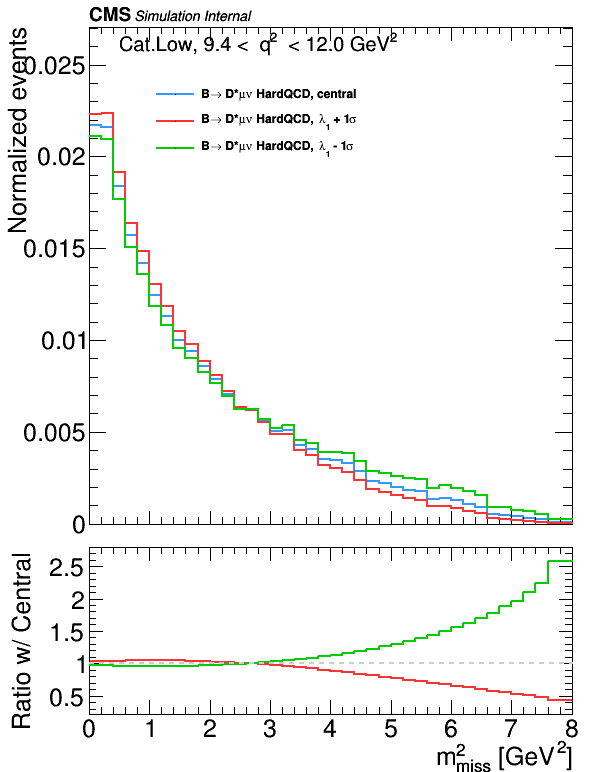

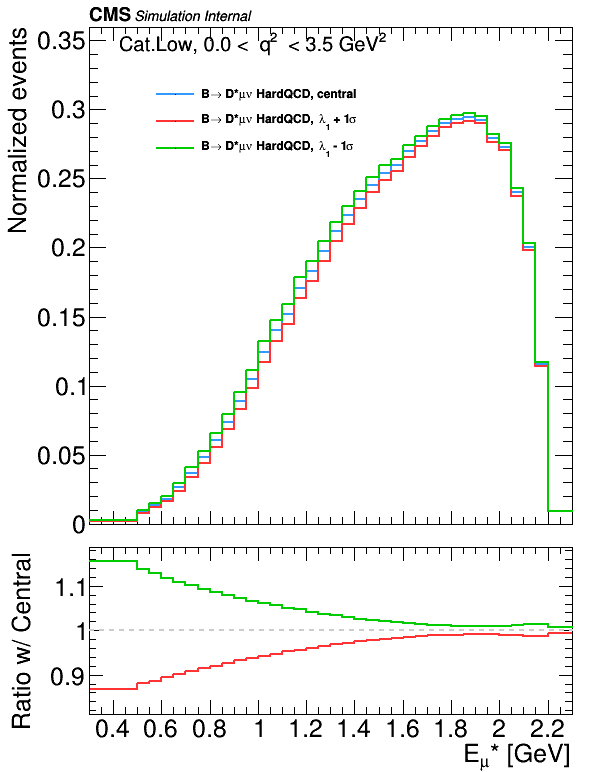

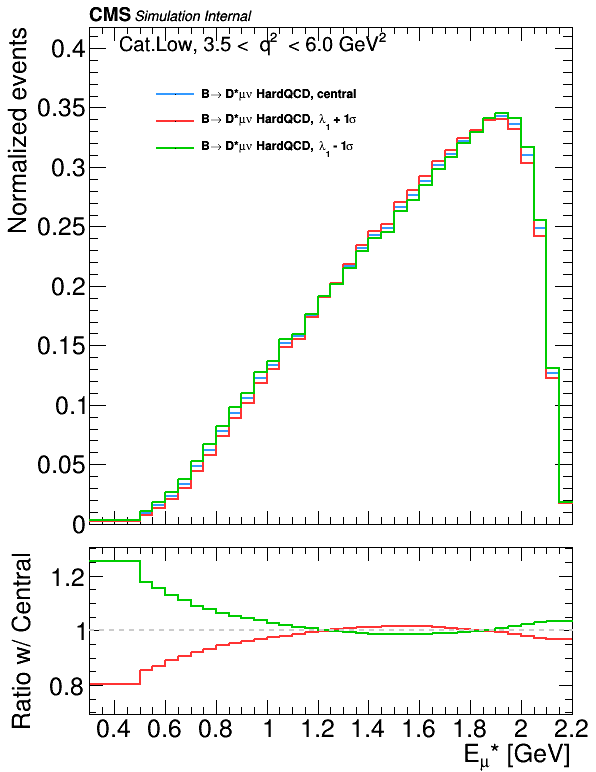

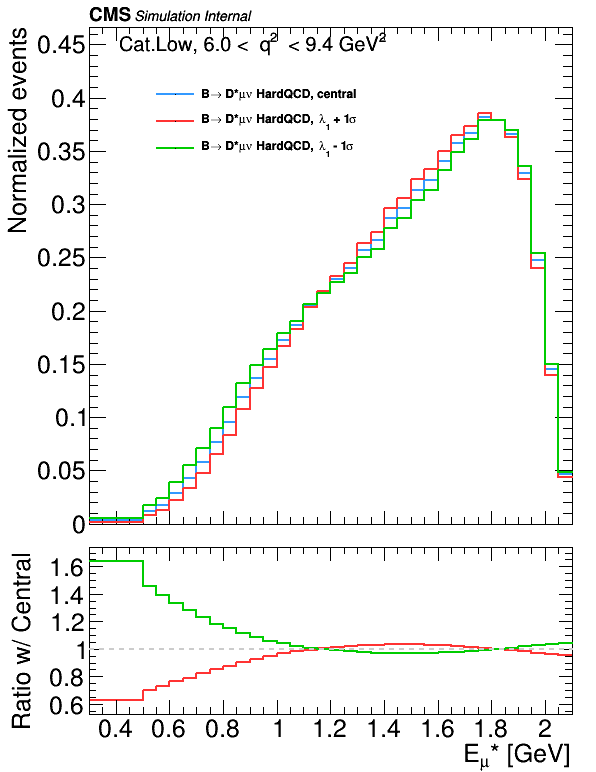

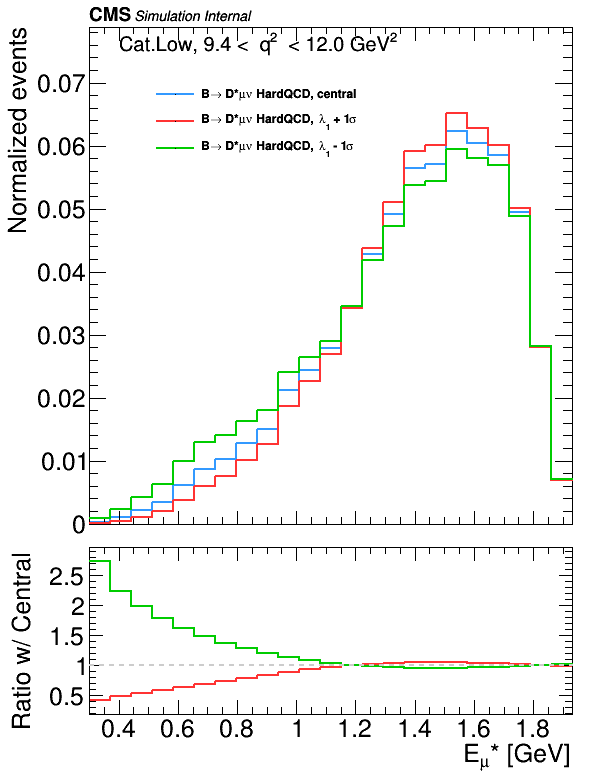

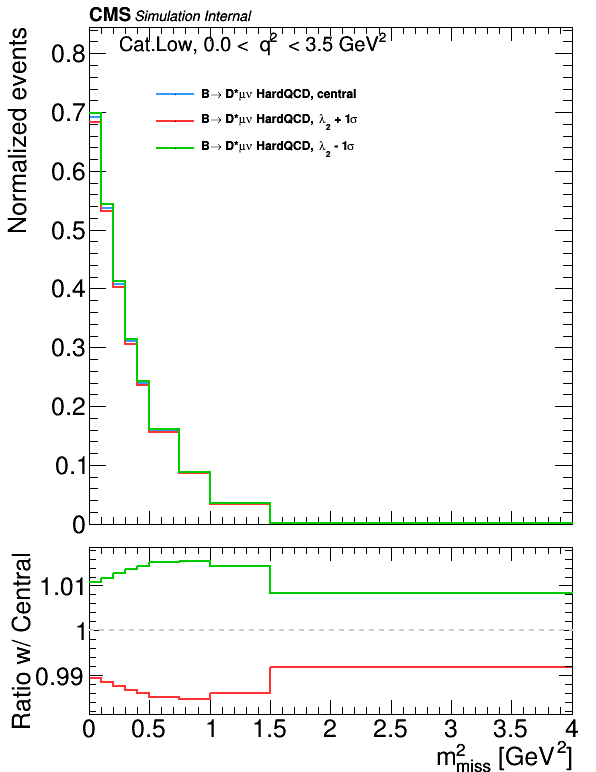

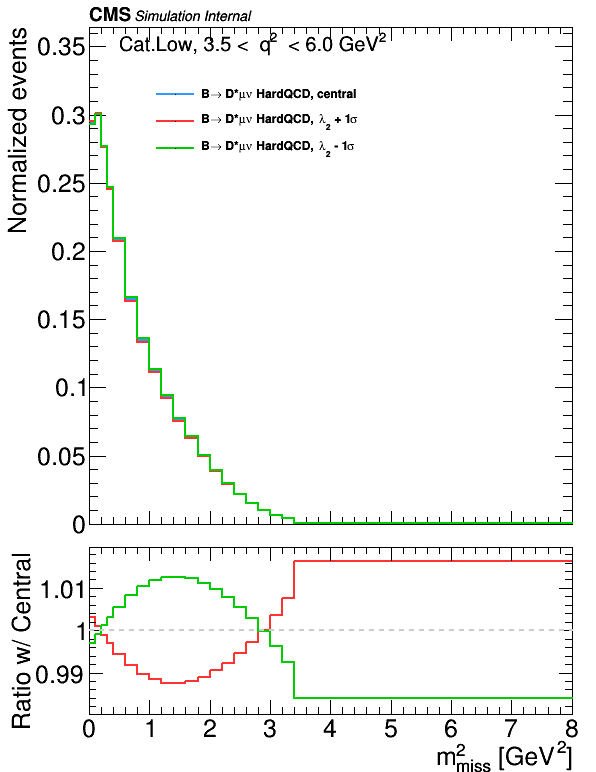

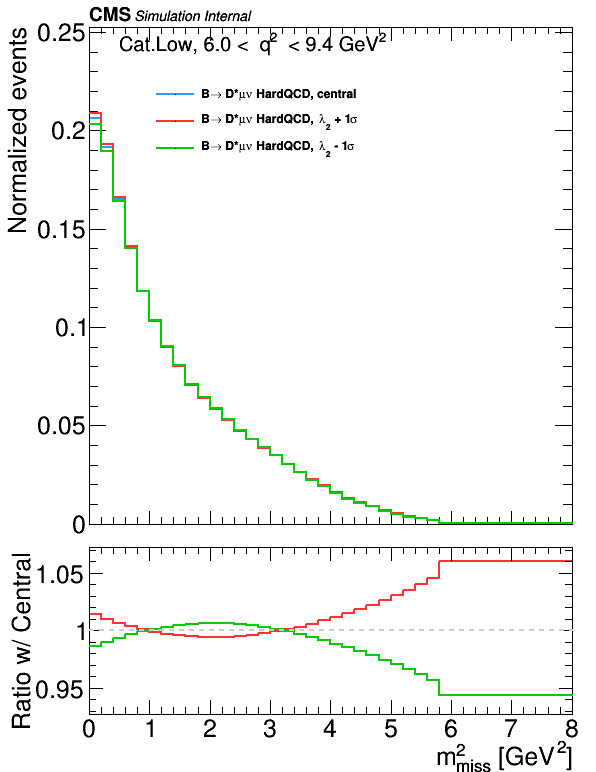

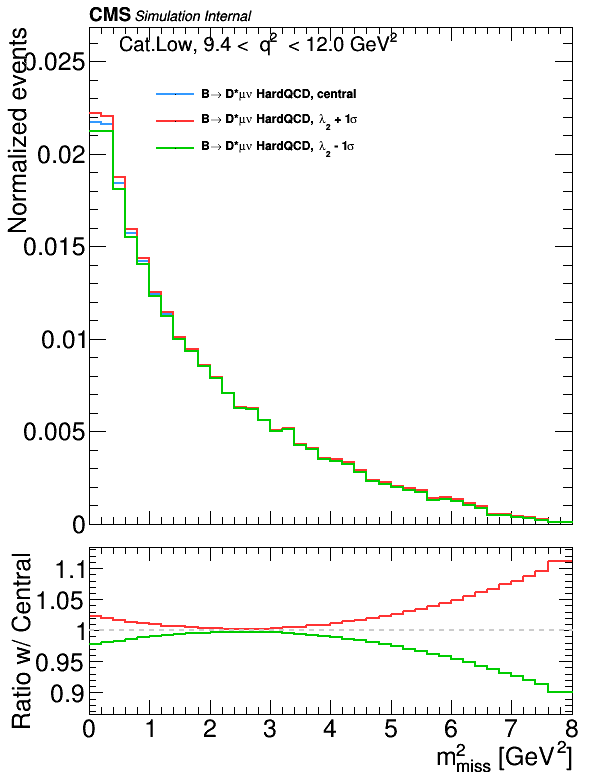

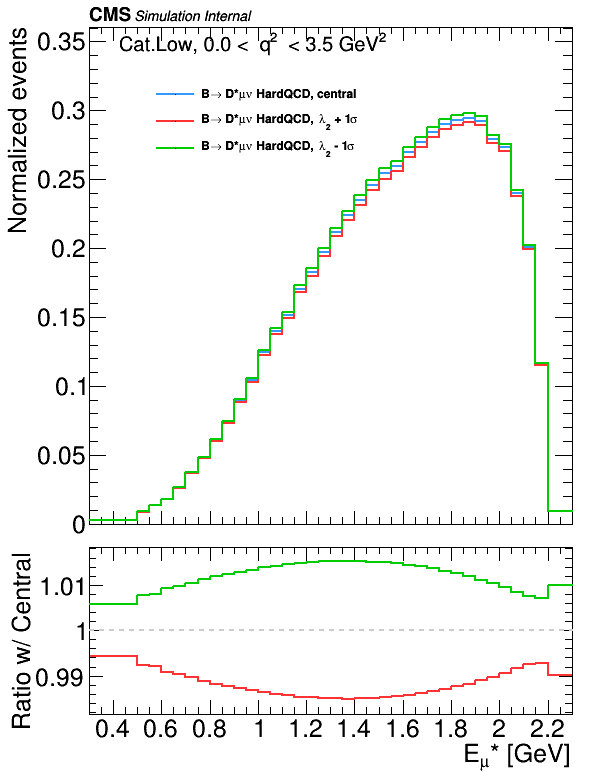

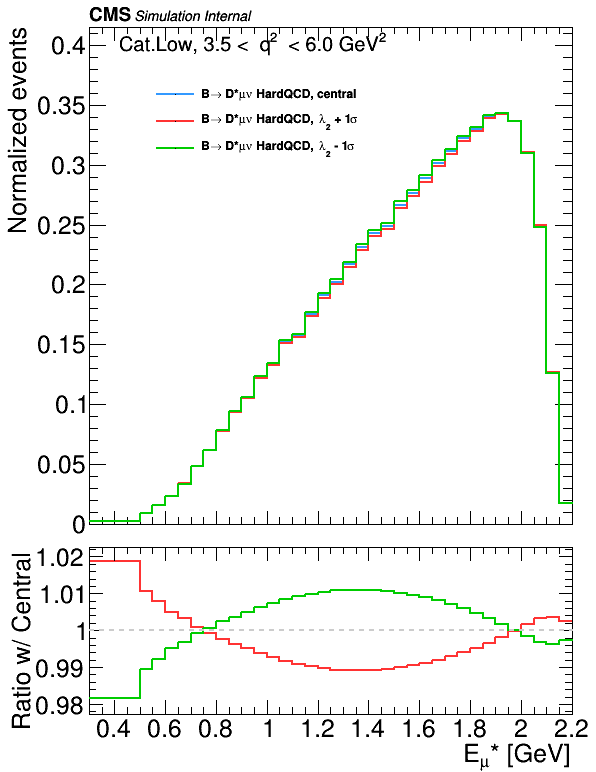

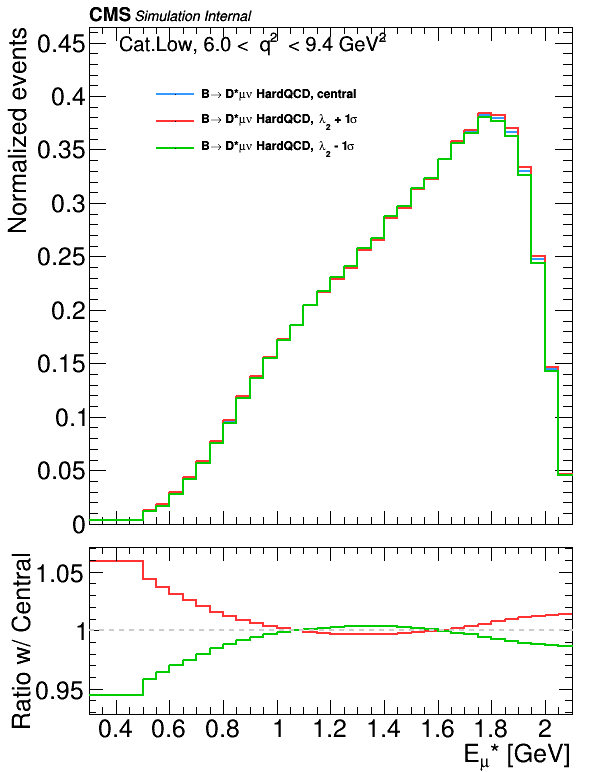

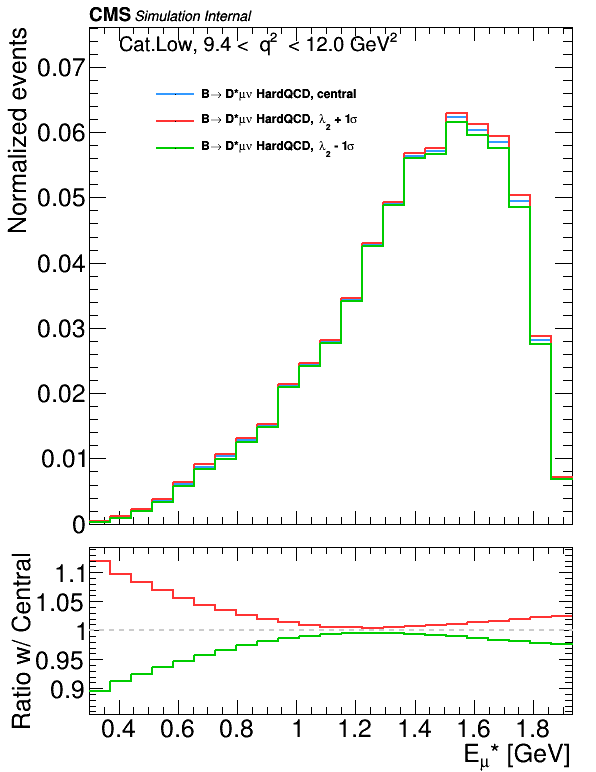

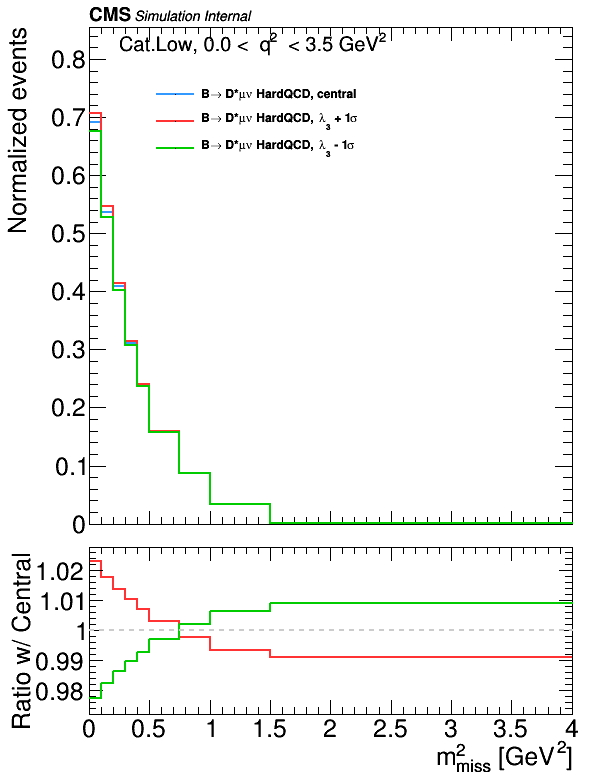

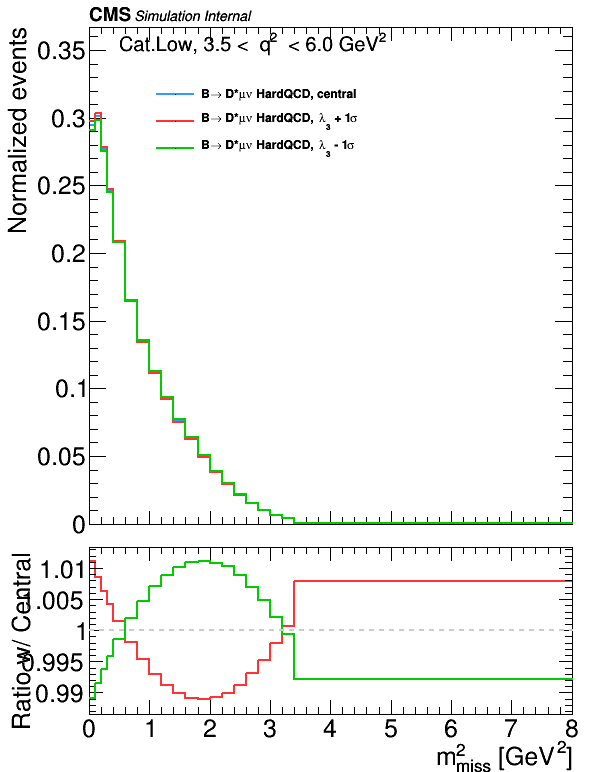

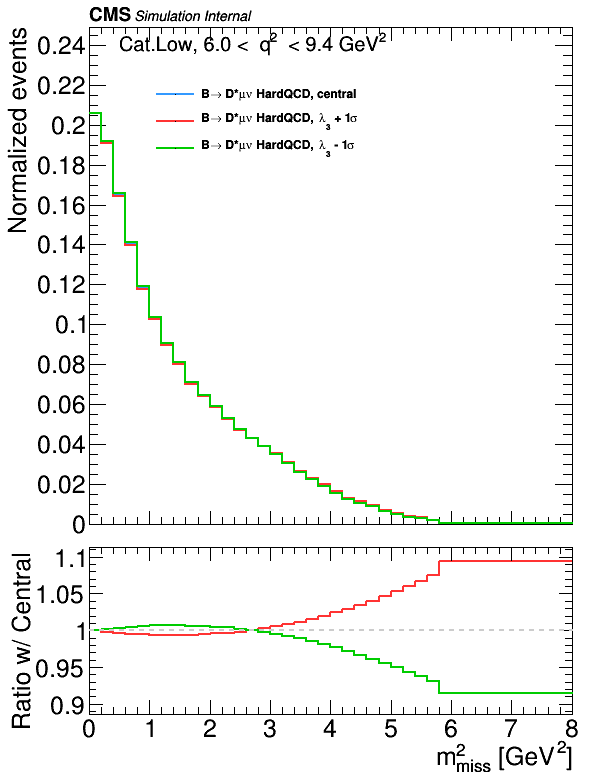

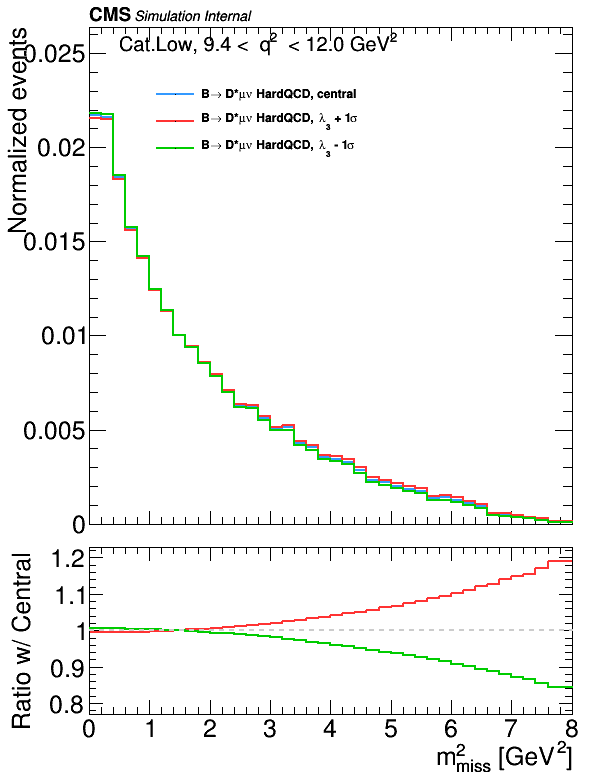

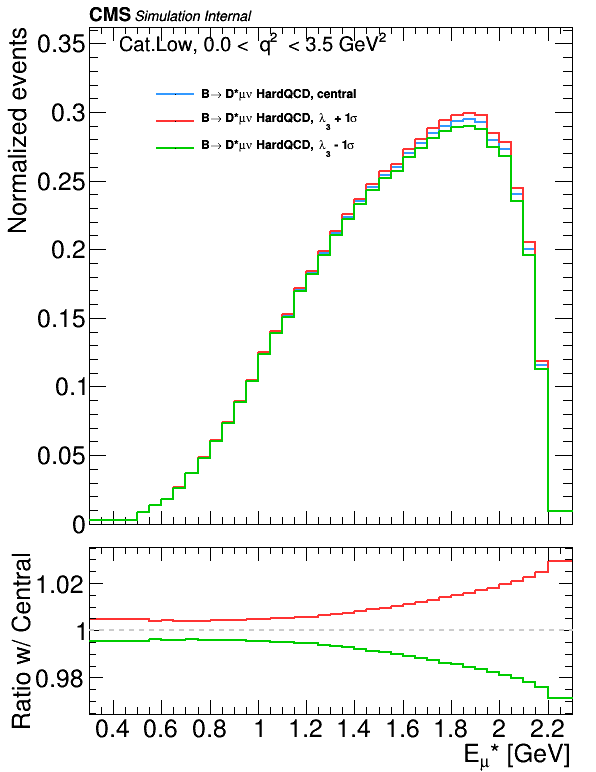

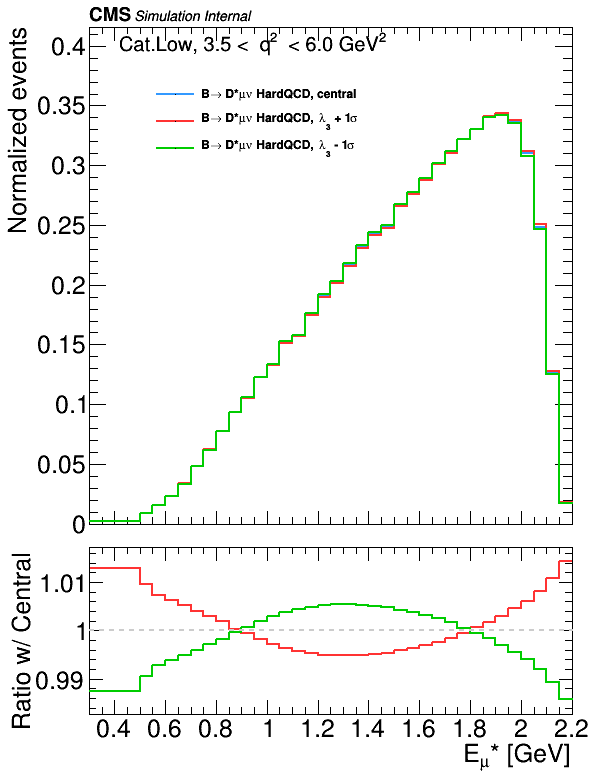

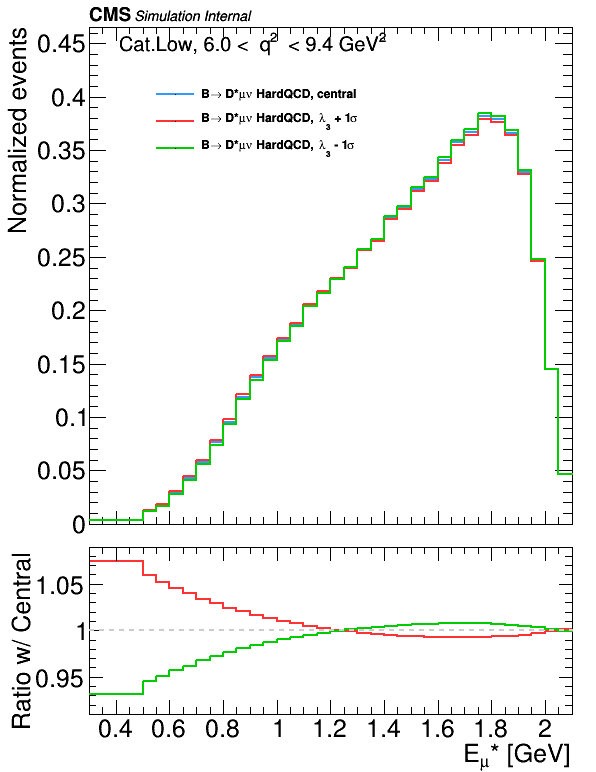

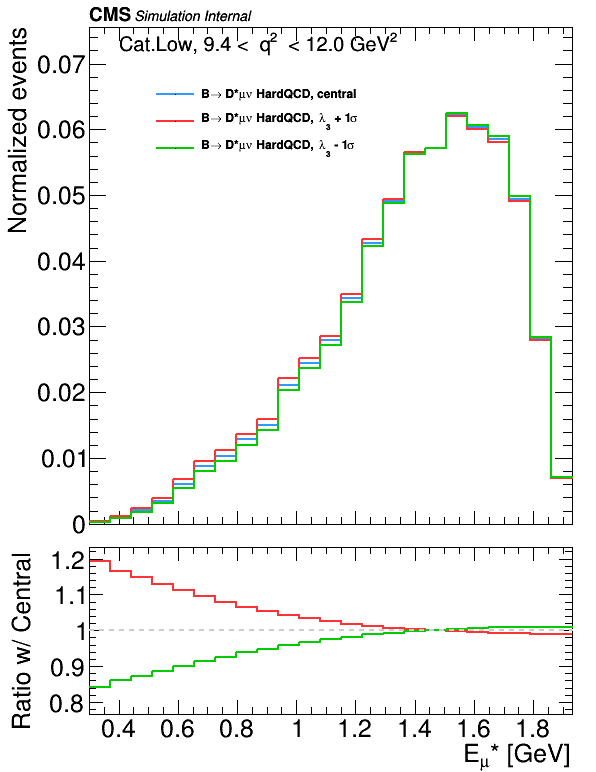

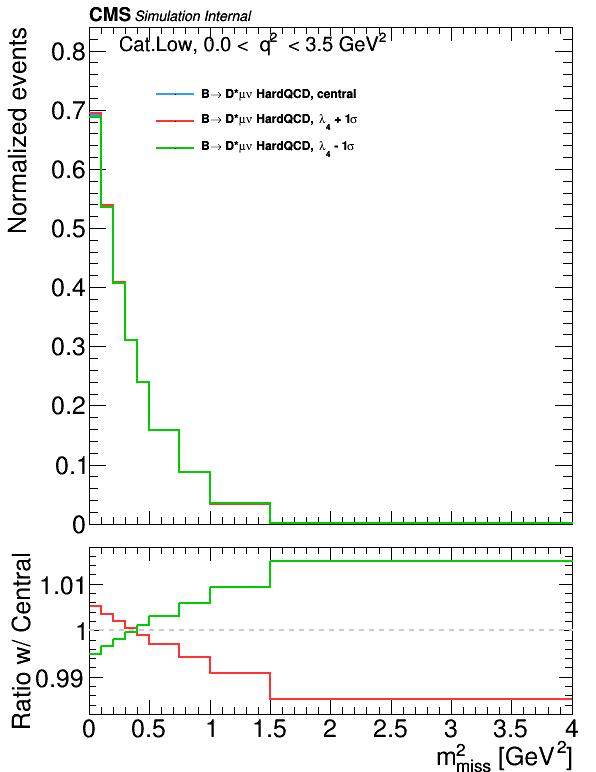

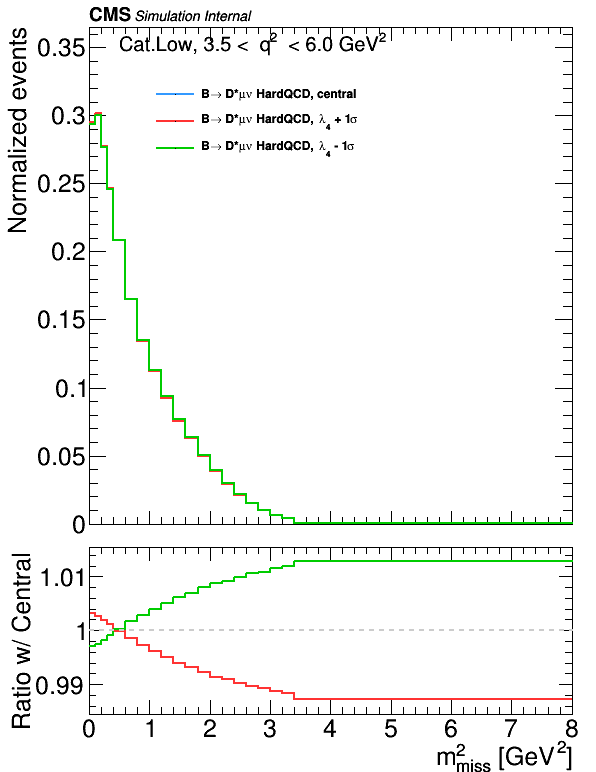

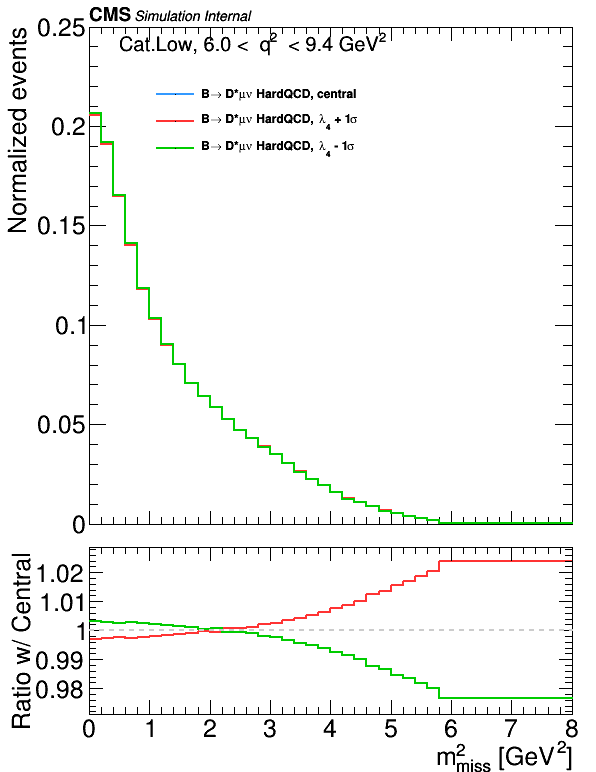

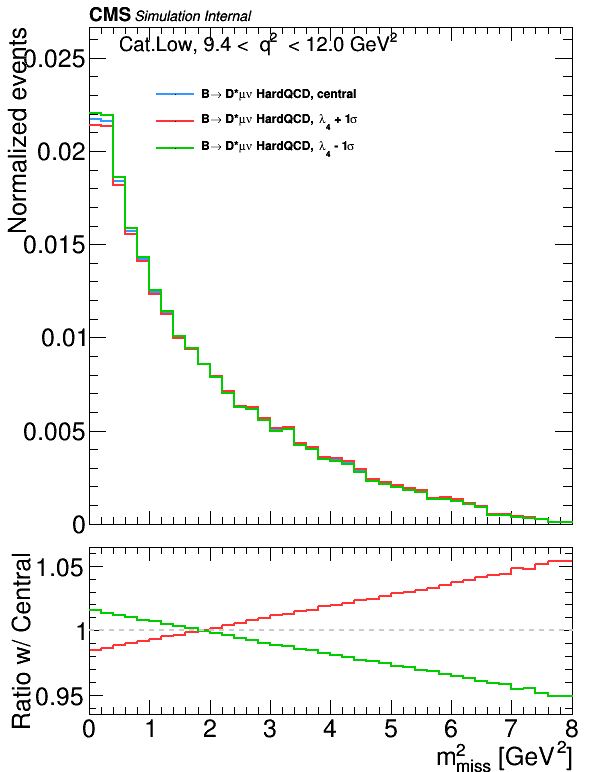

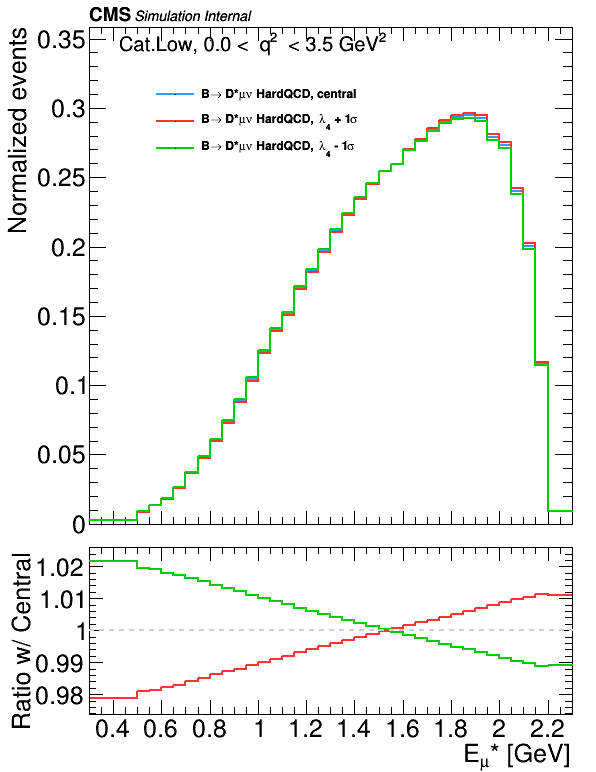

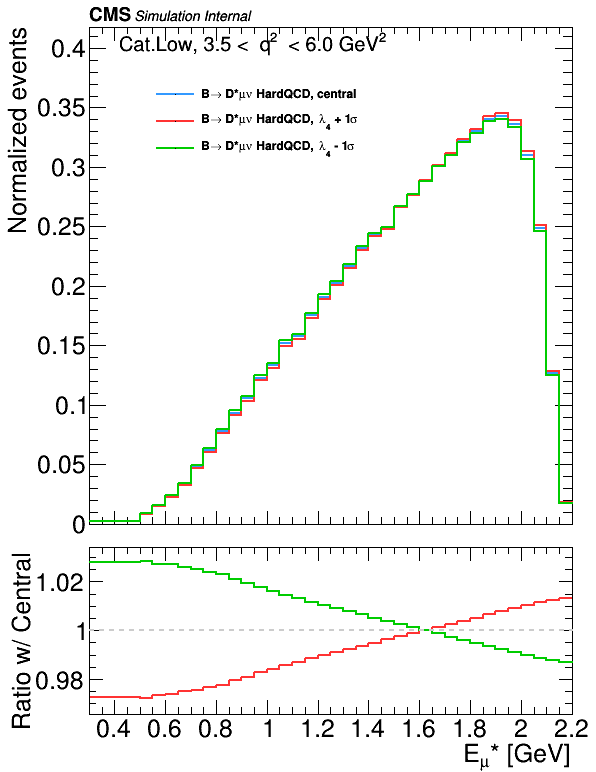

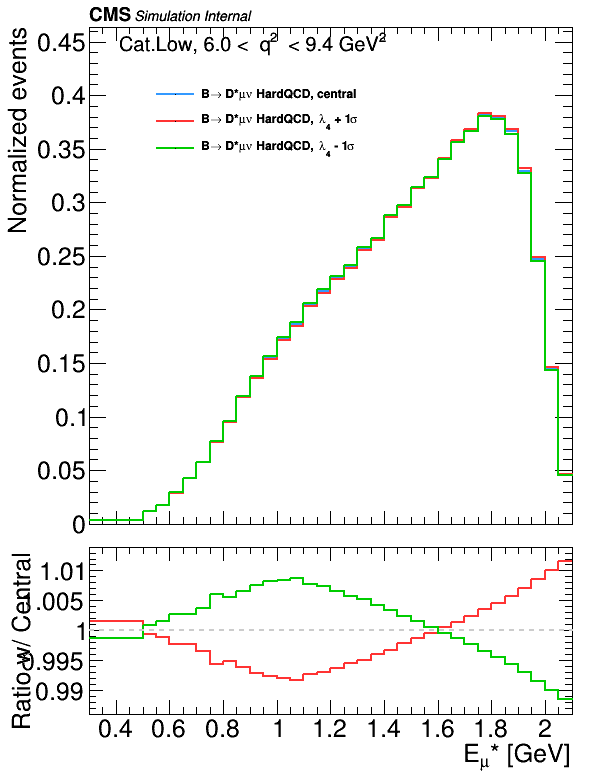

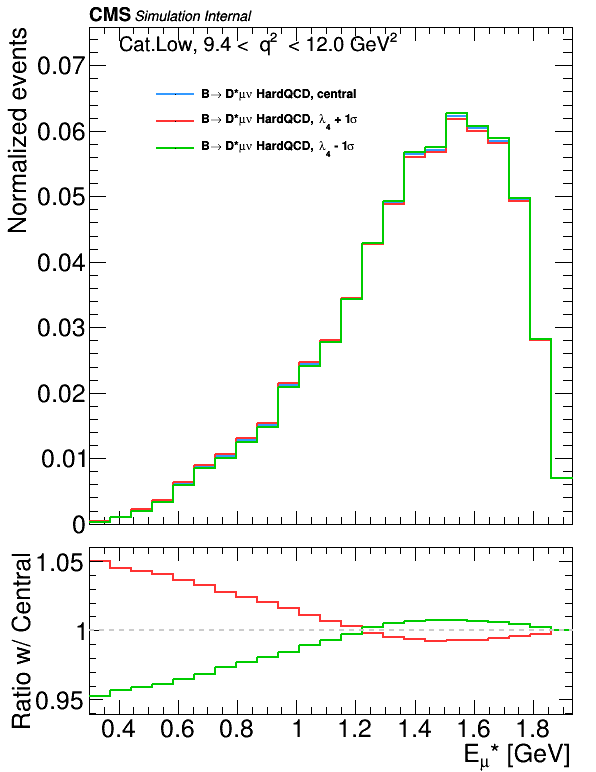

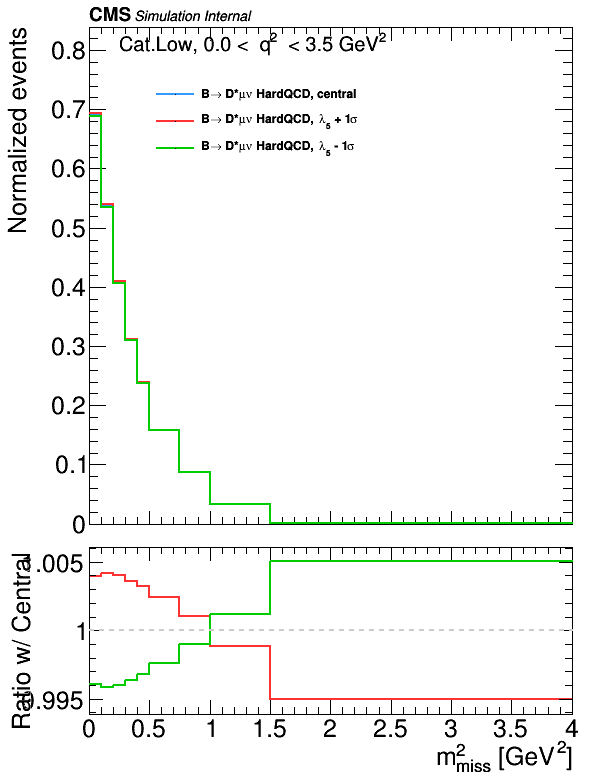

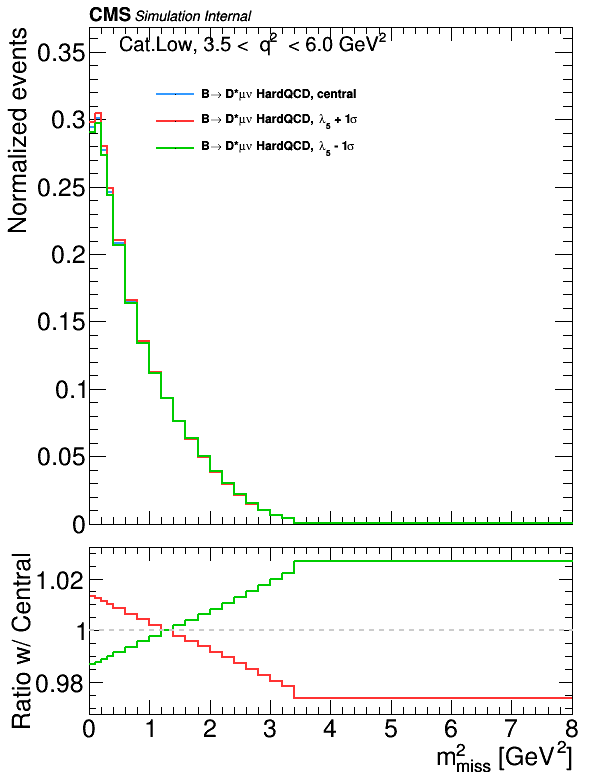

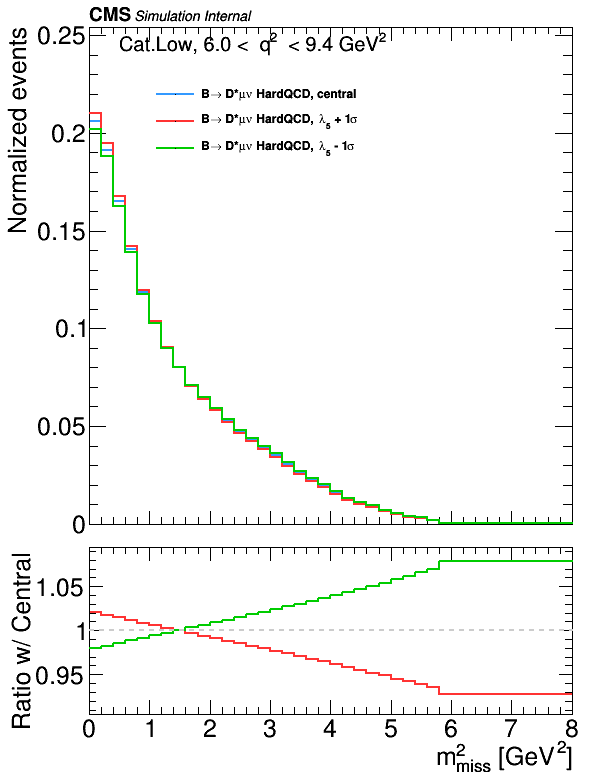

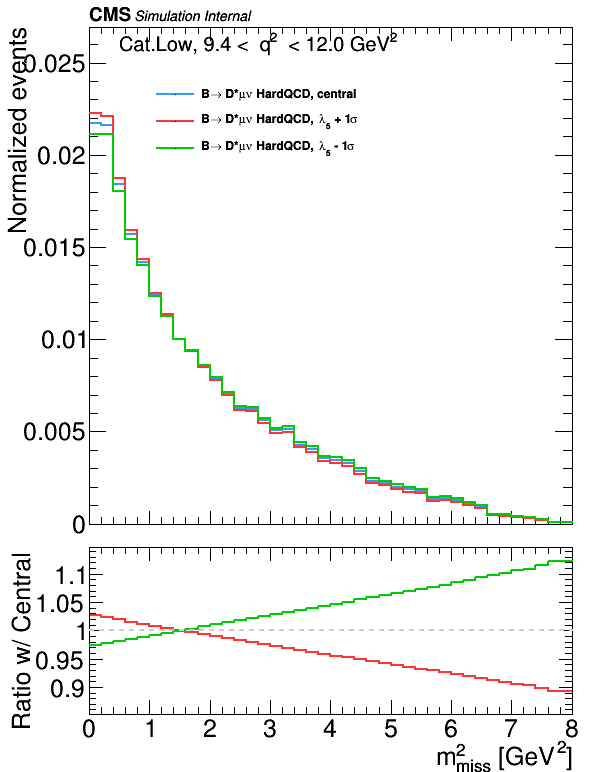

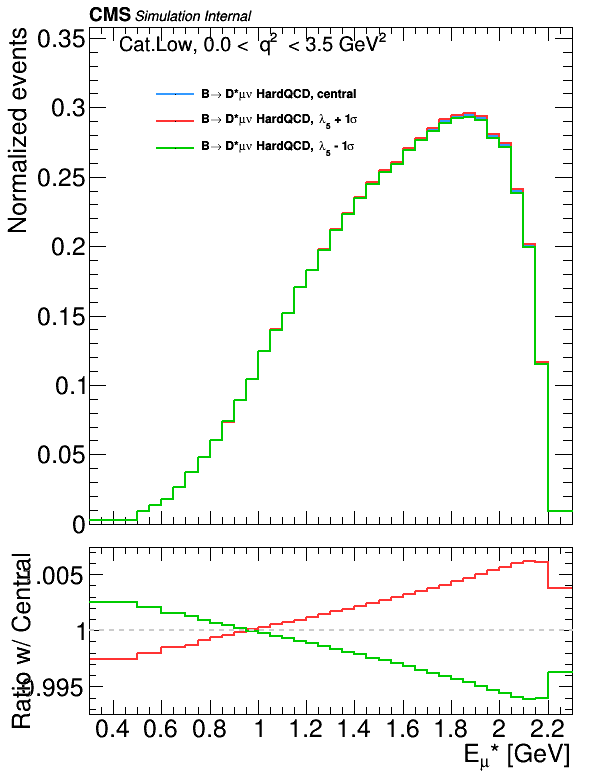

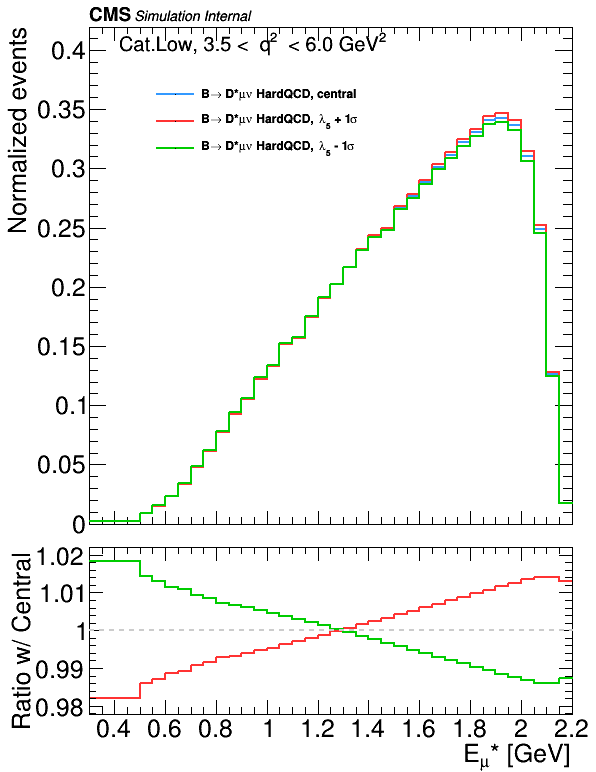

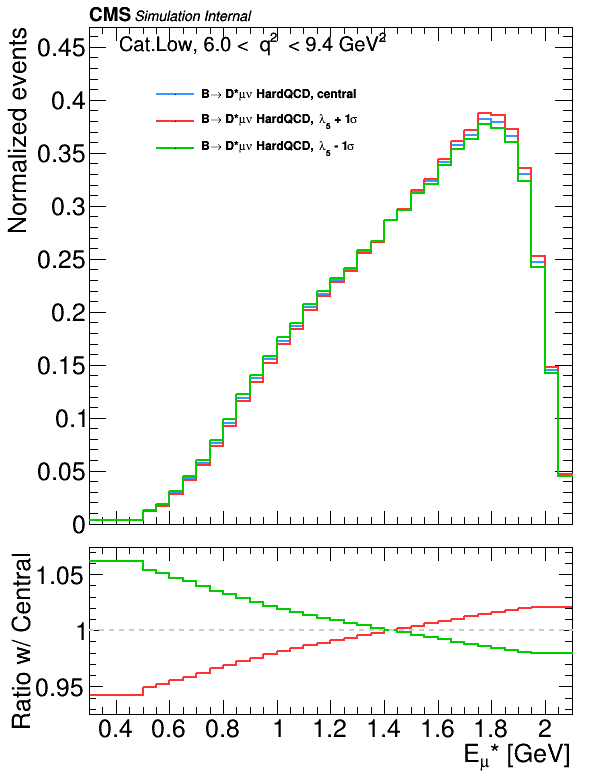

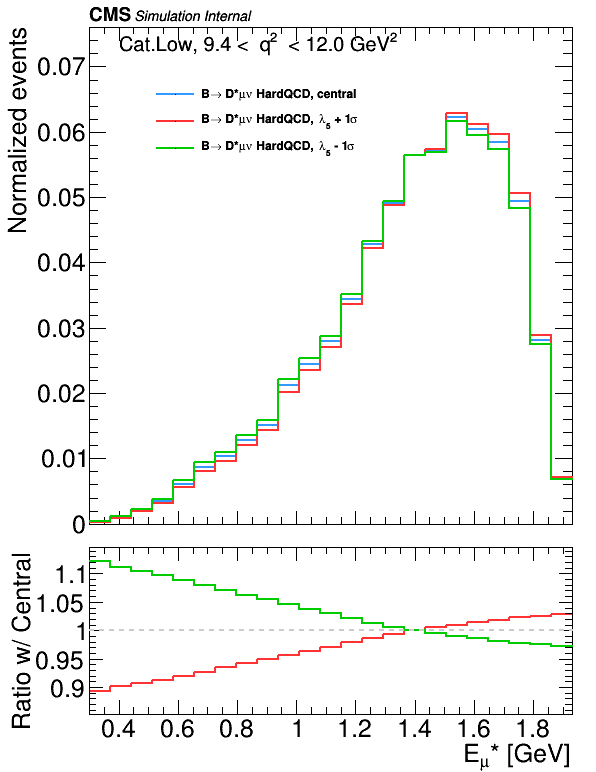

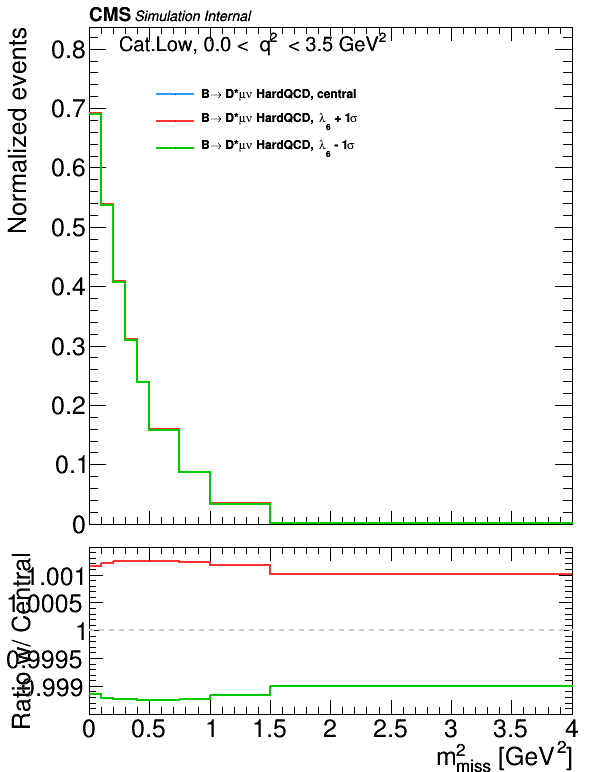

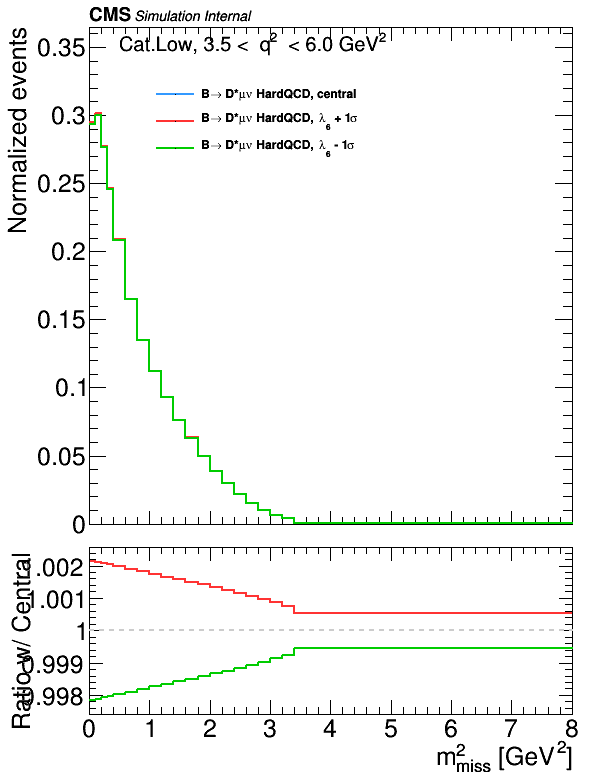

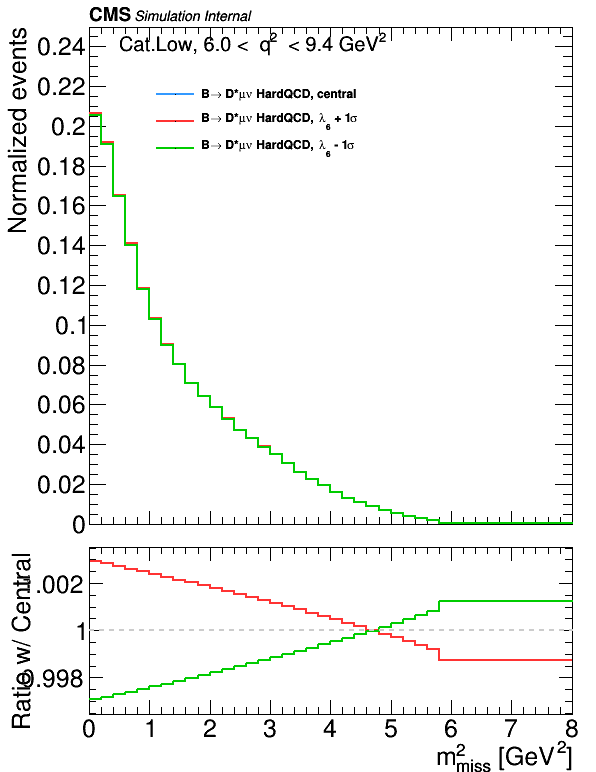

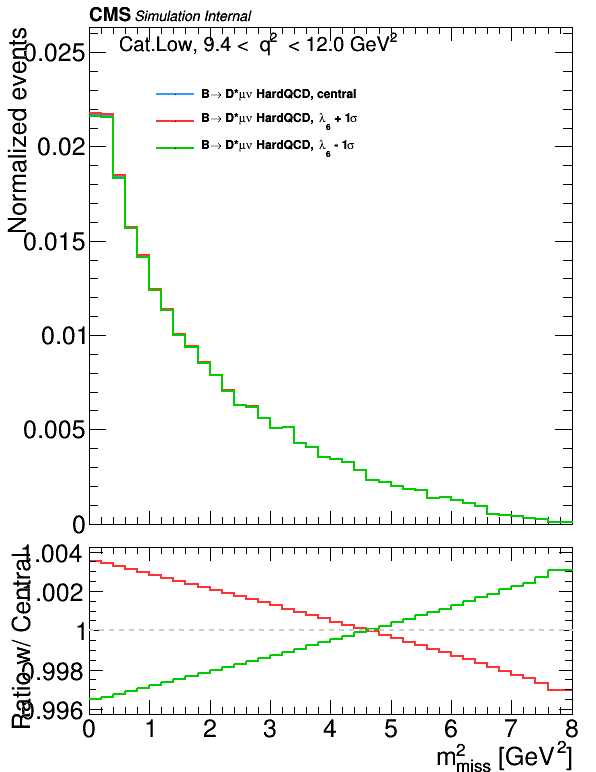

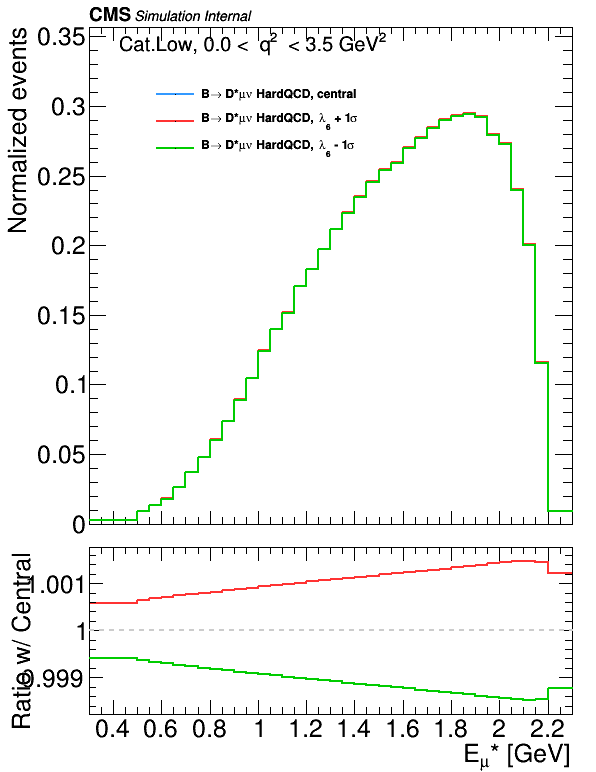

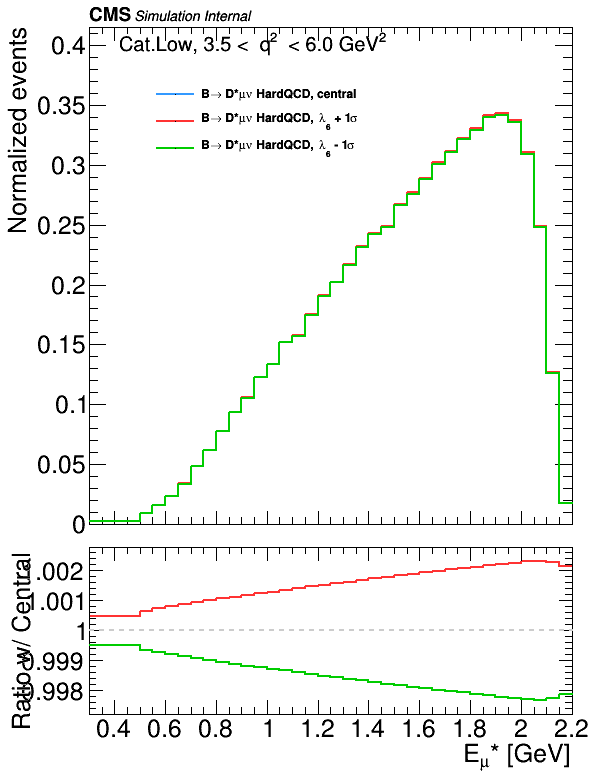

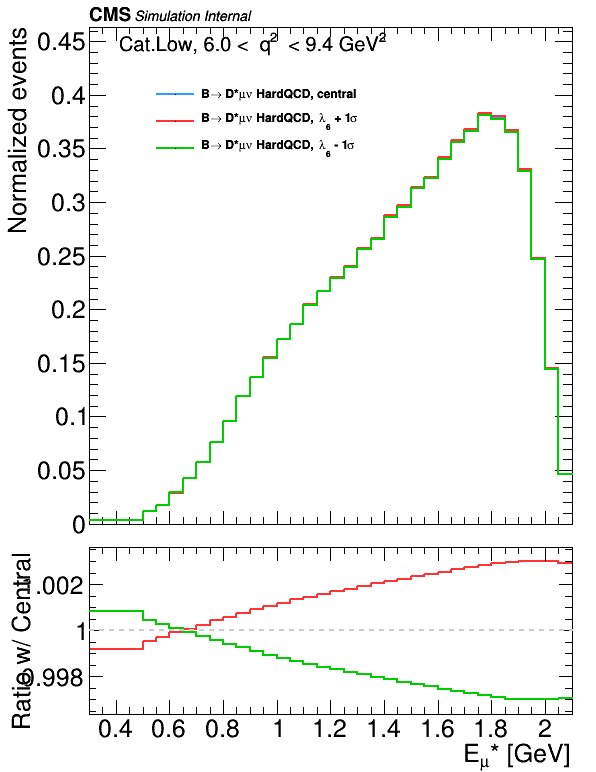

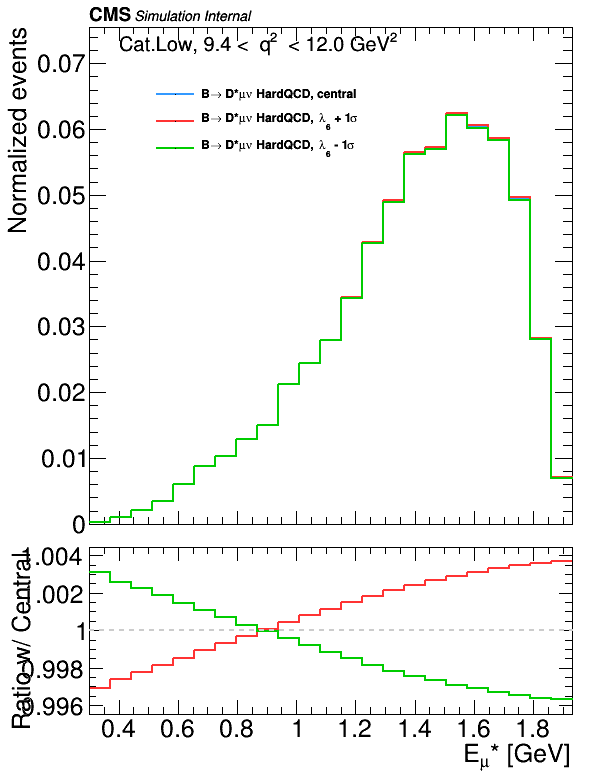

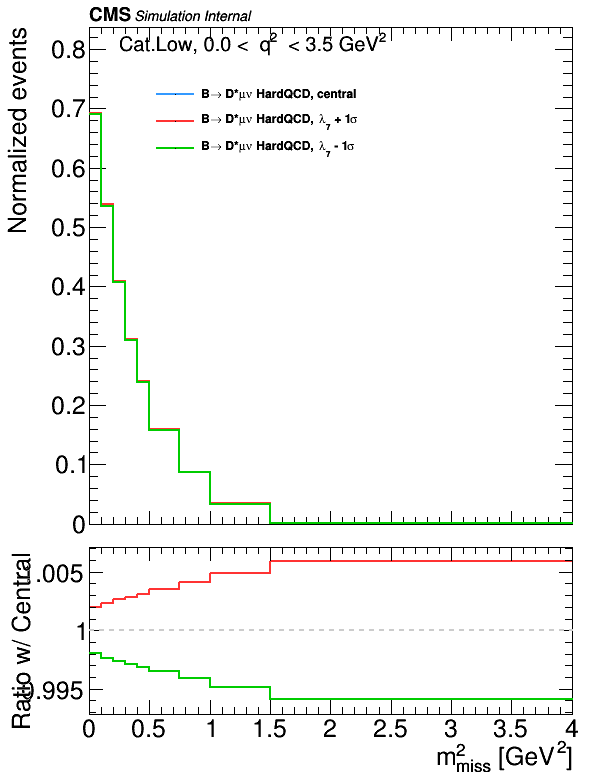

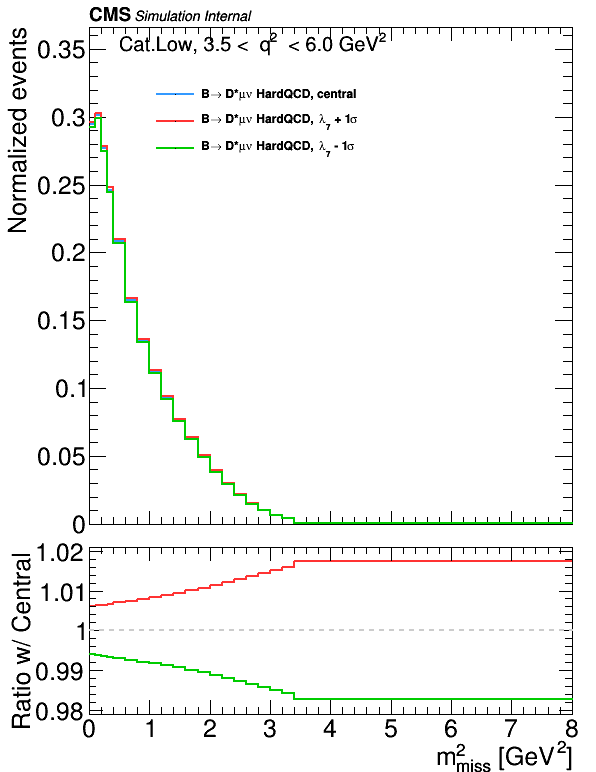

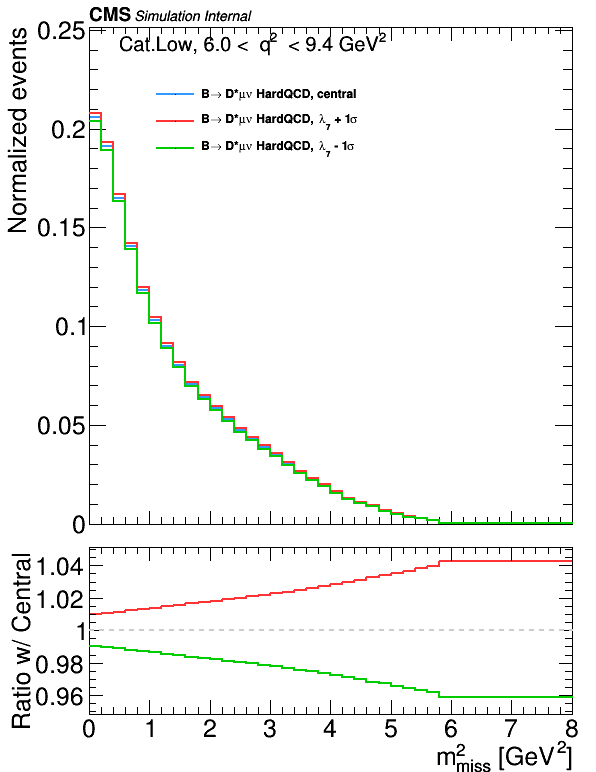

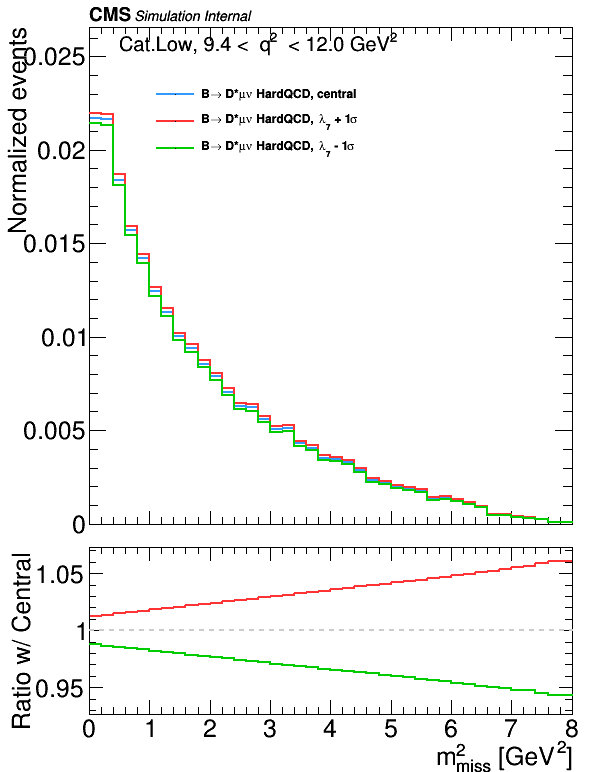

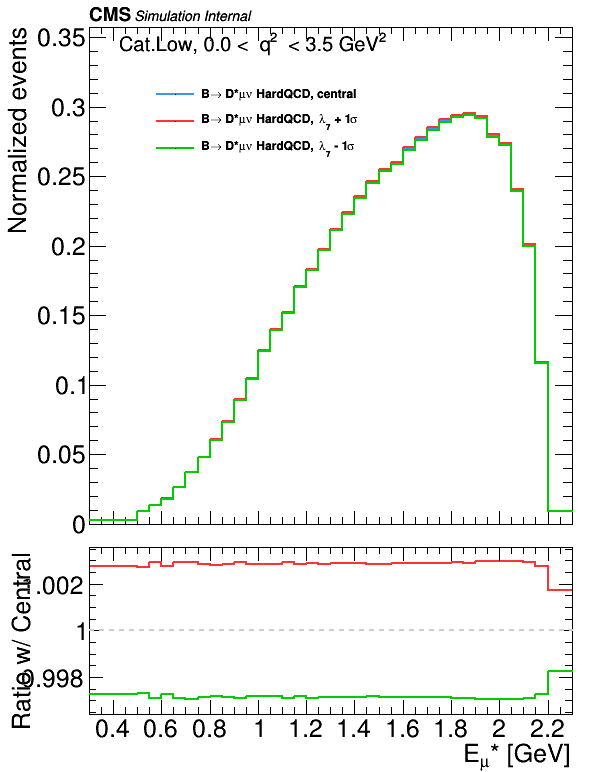

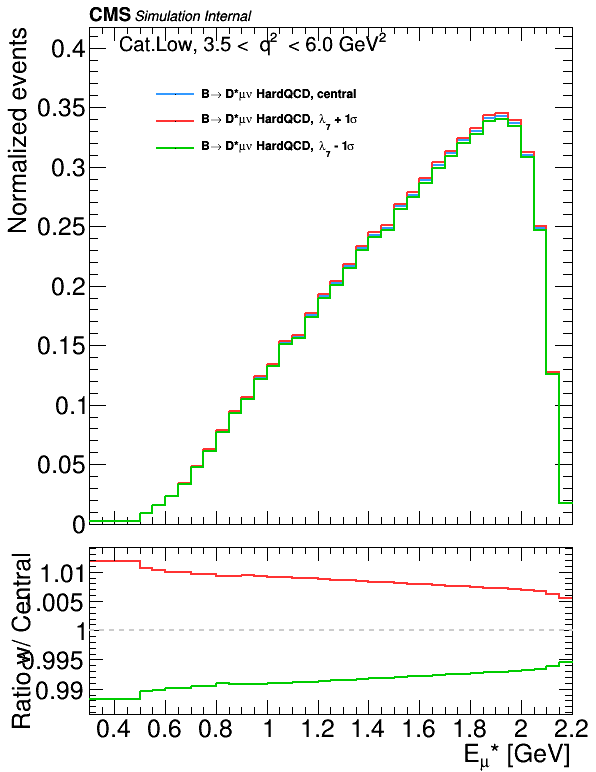

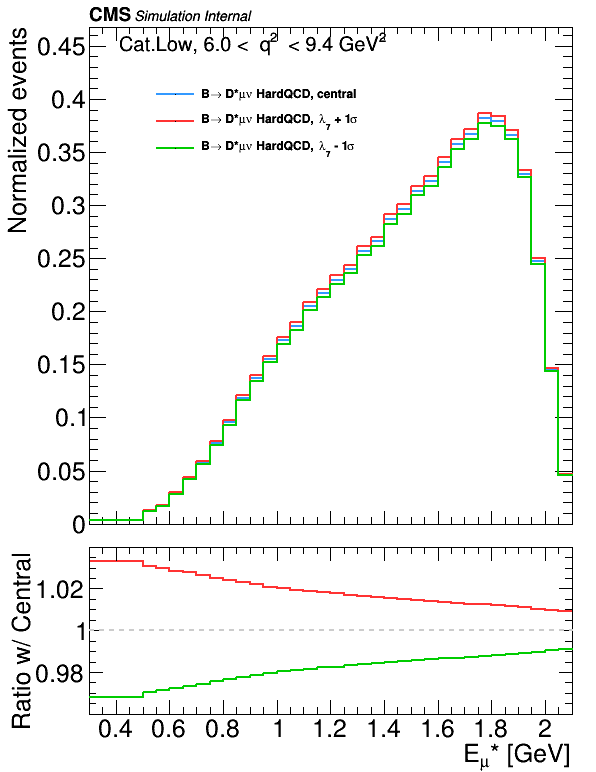

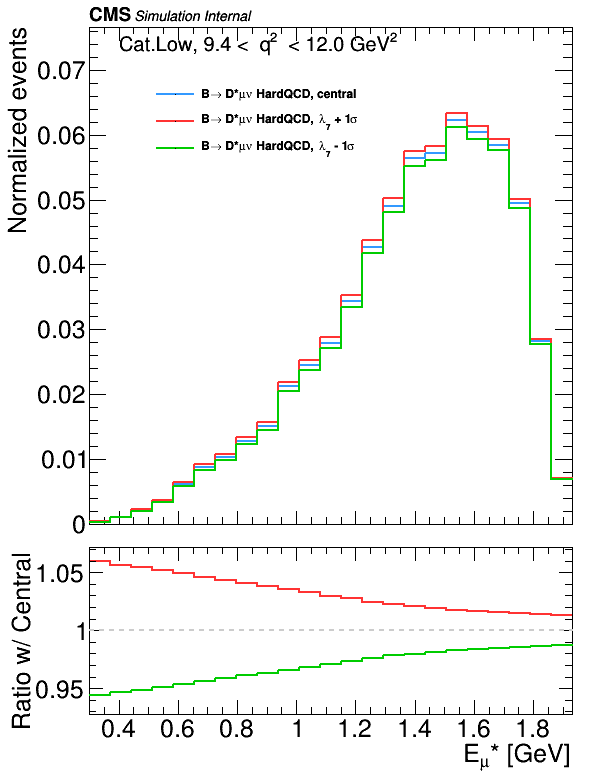

In [122]:
canvasOut = []
for shapeVar in range(1, len(calReader.betaVar)+1):
    for var in ['M2_miss', 'Est_mu']:
        for i_q2 in range(len(binning['q2'])-1):
            q2_l = binning['q2'][i_q2]
            q2_h = binning['q2'][i_q2 + 1]
            q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)
            selSoft = np.logical_and(dsSoft['q2'] > q2_l, dsSoft['q2'] <= q2_h)
            selHard = np.logical_and(dsHard['q2'] > q2_l, dsHard['q2'] <= q2_h)

            c = make_comp_plot_1D(
                [
                    [dsHard[var][selHard], 'B#rightarrow D*#mu#nu HardQCD, central'],
                    [dsHard[var][selHard], 'B#rightarrow D*#mu#nu HardQCD, #lambda_{{{}}} + 1#sigma'.format(shapeVar)],
                    [dsHard[var][selHard], 'B#rightarrow D*#mu#nu HardQCD, #lambda_{{{}}} - 1#sigma'.format(shapeVar)],
                ],
                weights=[weights[selHard], 
                         calReader.getWeights(shapeVar)[selHard], 
                         calReader.getWeights(-shapeVar)[selHard]],
                scale_histo = 3*[1./selHard.shape[0]],
                hTags = ['Central'] + 2*['h'],
                binning=binning[var][i_q2], 
                setLog='', miny=1e-6,
                axis_title = [xAx_title.get(var, var), 'Normalized events'],
                leg_loc=[0.25, 0.7, 0.35, 0.15],
                tag=category +'_'+str(shapeVar)+'_'+ var+'_q2bin'+str(i_q2),
                ratioPlots=True, showError=False
            )
            txt.DrawLatexNDC(0.2, 0.92, 'Cat.' + category.capitalize() + ', ' + q2_txt)

            c.SaveAs(webDir + category + 'oneShot'+str(shapeVar)+'_' + var + '_q2bin'+str(i_q2) + '.png')
            canvasOut.append(c)

## Compute the corrections

In [ ]:
def make_histos(inputs, #[x, sample, color=-1 (auto), ]
                transformX = None,
                binning=[None, None, None],
                setLog = '',
                miny = 0,
                axis_title = ['', ''],
                scale_histo = 'norm',
                opt='',
                tag=''
               ): 
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hOut = {}
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        if isinstance(scale_histo, list):
            auxScale = scale_histo[i]
        else:
            auxScale = scale_histo
        h = create_TH1D(x, 
                        binning=binning if i==0 else hOut.values()[0].binning, 
                        axis_title=axis_title,
                        scale_histo=auxScale, 
                        widthNorm=True,
                        opt=opt,
                       )
        h.SetLineColor(colors[i])
        hOut[label] = h
            
    m = SetMaxToMaxHist(hOut.values())
    hOut[inputs[0][1]].GetYaxis().SetRangeUser(miny, m)
    
    return hOut

In [ ]:
histos = {}
corrections = {}

for var in ['M2_miss', 'Est_mu']:
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        tag=category +'_'+ var+'_q2bin'+str(i_q2)
        print tag
        selSoft = np.logical_and(dsSoft['q2'] > q2_l, dsSoft['q2'] <= q2_h)
        selHard = np.logical_and(dsHard['q2'] > q2_l, dsHard['q2'] <= q2_h)
        
        hDic = make_histos(
            [
                [dsHard[var][selHard], 'HardQCD'],
                [dsSoft[var][selSoft], 'SoftQCD'],
            ],
            scale_histo = [1./selHard.shape[0], 1./selSoft.shape[0]],
            binning=binning[var][i_q2], 
            setLog='', miny=1e-6,
            axis_title = [xAx_title.get(var, var), 'Normalized events'],
            tag=tag
        )
        histos[tag] = hDic
        
        hS = hDic['SoftQCD']
        hH = hDic['HardQCD']
        
        out = []
        for ib in range(1, hS.GetNbinsX()+1):
            n = max(0, hS.GetBinContent(ib))
            d = hH.GetBinContent(ib)
            x = hS.GetBinCenter(ib)
            xWidth = 0.5*hS.GetBinWidth(ib)
            if d == 0:
                w = 1
                err = 0.5
                continue

            en = 0.
            ed = 0.
            if n > 0: en = hS.GetBinError(ib)/n
            if d > 0: ed = hH.GetBinError(ib)/d
            w = n/d
            if en != 0 and ed != 0:
                err = w*np.hypot(en, ed)
            elif en == 0:
                err = 0.5
        
            out.append([x, w, err, xWidth])
        out = np.array(out)
            
        deg = 1
        beta, covBeta = np.polyfit(out[:,0], out[:,1], deg=deg, full=False, w=1./out[:,2], cov='unscaled')

        res = (out[:,1] - np.polyval(beta, out[:,0]))/out[:,2]

        chi2stat = np.sum(np.square(res))
        dof = res.shape[0]-deg-1
        pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
        print 'Chi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)
        
        eigVal, eigVec = np.linalg.eig(covBeta)
        eigSig = np.sqrt(eigVal)

        betaVar = []
        for i in range(eigSig.shape[0]):
            betaVar.append(eigSig[i]*eigVec[:, i])
        
        corrections[var+'_q2bin'+str(i_q2)] = [beta, betaVar]
        
        plt.rcParams.update({'font.size': 20})
        f = plt.figure(figsize=(8,6))
        plt.errorbar(out[:,0], out[:,1], yerr=out[:,2], xerr=out[:,3], fmt='.k', label='Soft/Hard')

        x = np.linspace(out[0, 0] - out[0,3], out[-1, 0] + out[-1,3], 100)
        plt.plot(x, np.polyval(beta, x), '-', 
                 color='#1f77b4', 
                 label='w, Central\n'+r'$\beta = [{:.2f}, {:.2f}]$'.format(*beta))

        colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(len(betaVar)):
            yP = np.polyval(beta+betaVar[i], x)
            yM = np.polyval(beta-betaVar[i], x)
            plt.plot(x, yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
            plt.plot(x, yM, '--', color=colors[i])

        plt.plot(x , [1]*len(x), ':k')
        plt.legend(loc='best', numpoints=1, fontsize=15)
        plt.xlabel(var)
        plt.ylabel('Soft/Hard')
        ymin, ymax = plt.ylim()
        ymin, ymax = plt.ylim(max(0, ymin), min(2, ymax))
        plt.xlim(0.9*np.min(x), 1.1*np.max(x))
        plt.text(x[-1] ,ymax*0.9, tag, horizontalalignment='right')
        plt.savefig(webDir+ 'ratiosFits/' + tag + '.png')
        print '\n'

pickle.dump(corrections, 
            open('/storage/user/ocerri/BPhysics/data/calibration/pythiaProcessesHardToSoft/poly'+category+'.pkl', 'wb'))

In [ ]:
class pythiaCalReader:
    def __init__(self, calibration_file):
            self.corrections = pickle.load(open( calibration_file, 'rb' ))


    def getWeights(self, df, 
                   shape=0, scale=1.,
                   q2bin=0
                   var='Est_mu'
                   clipLimits=[0.1,1.9]):
        
        beta = self.corrections

        sign = np.sign(shape)
        idx = np.abs(shape) - 1
        delta_p = sign*scale*self.betaVar[idx]
        
        w = np.polyval(self.beta + delta_p, B_pt)
        return np.clip(w, clipLimits[0], clipLimits[1])

## Draw plots

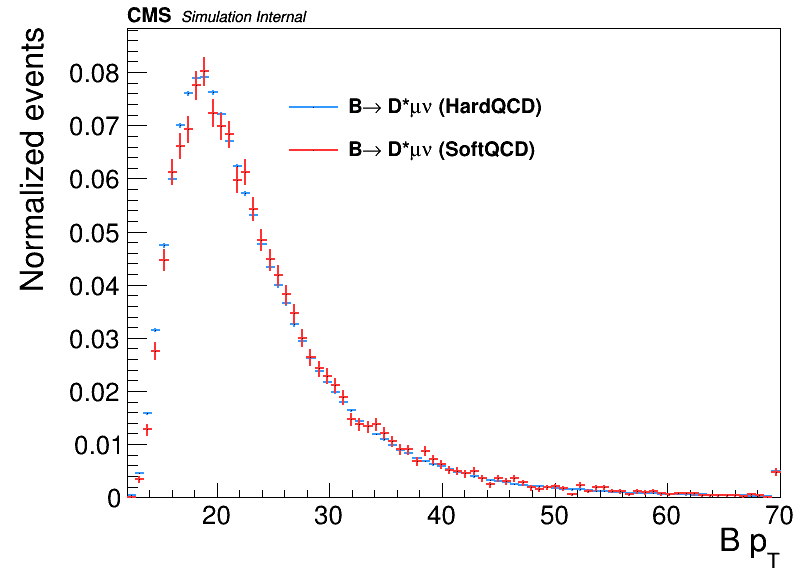

In [127]:
c = make_comp_plot_1D(
    [
        [dsHard['MC_B_pt'], 'B#rightarrow D*#mu#nu (HardQCD)'],
        [dsSoft['MC_B_pt'], 'B#rightarrow D*#mu#nu (SoftQCD)'],
    ],
    scale_histo = [1./dsHard['MC_B_pt'].shape[0], 1./dsSoft['MC_B_pt'].shape[0]],
    binning=[80, 12, 70], 
    setLog='', miny=1e-6,
    axis_title = ['B p_{T}', 'Normalized events'],
    leg_loc=[0.35, 0.7, 0.35, 0.15],
    tag=category +'_'+ var+'_q2bin'+str(i_q2)
)

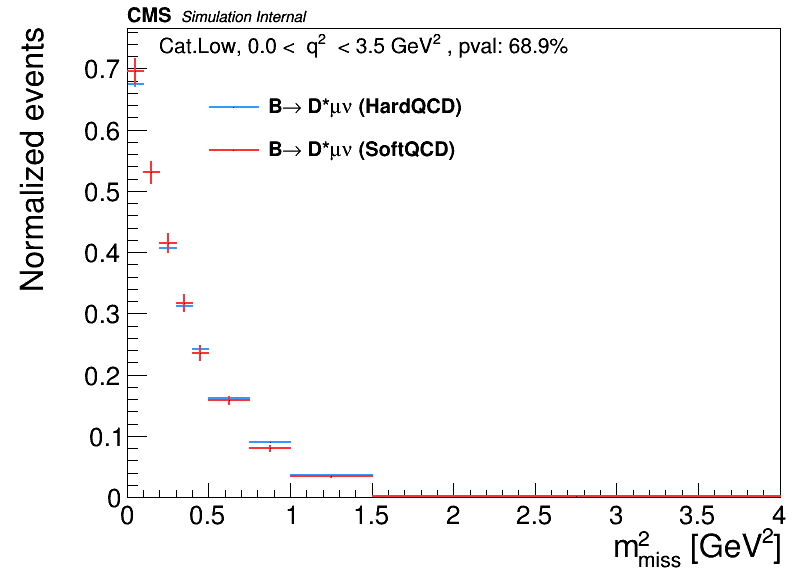

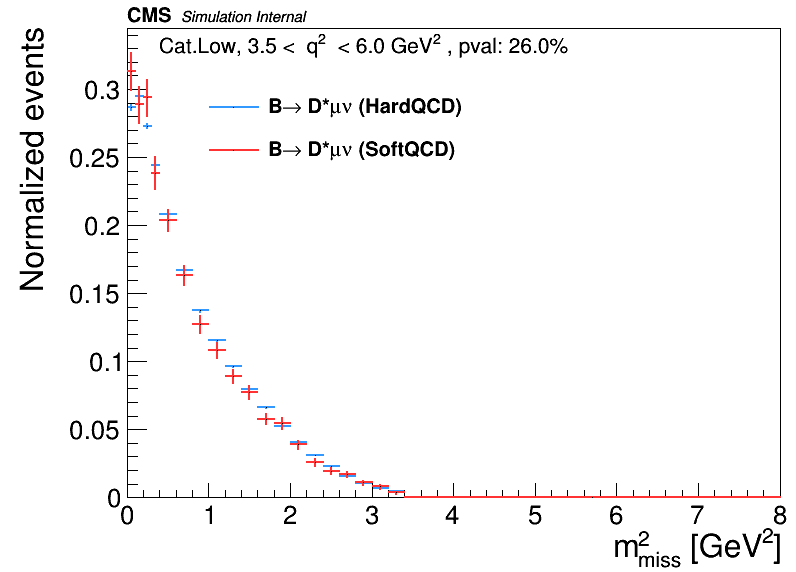

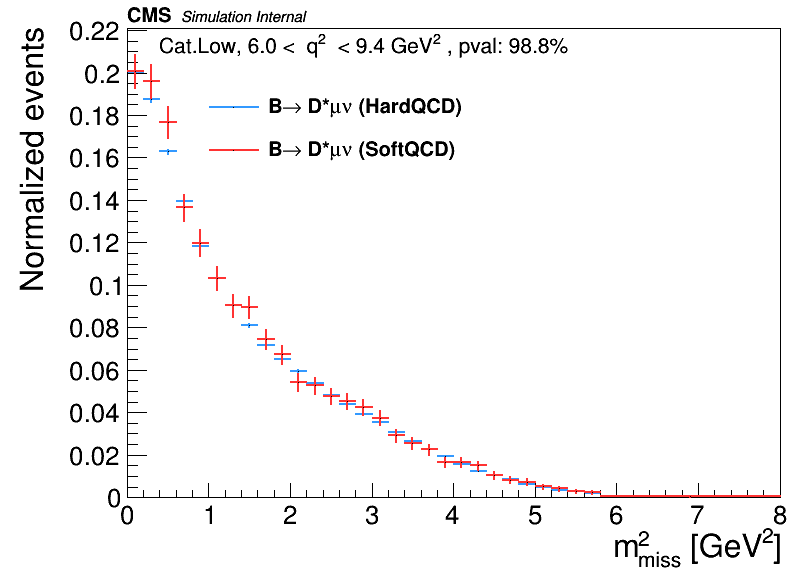

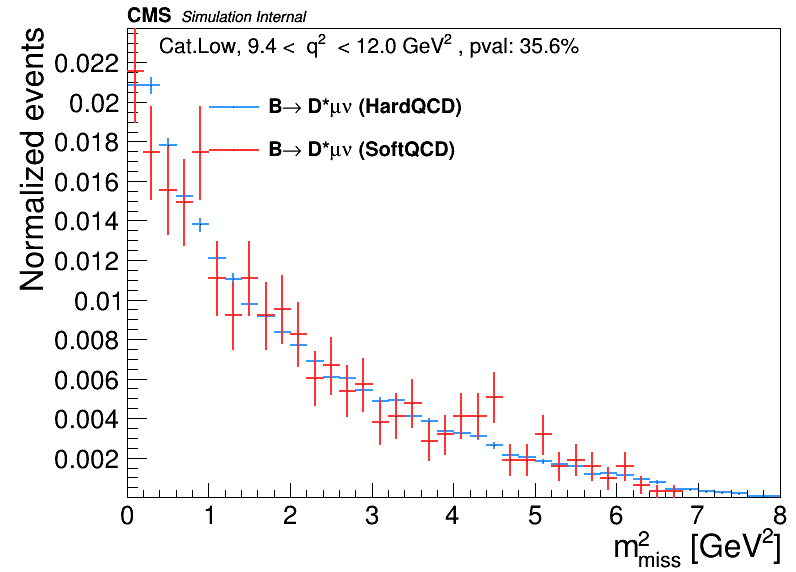

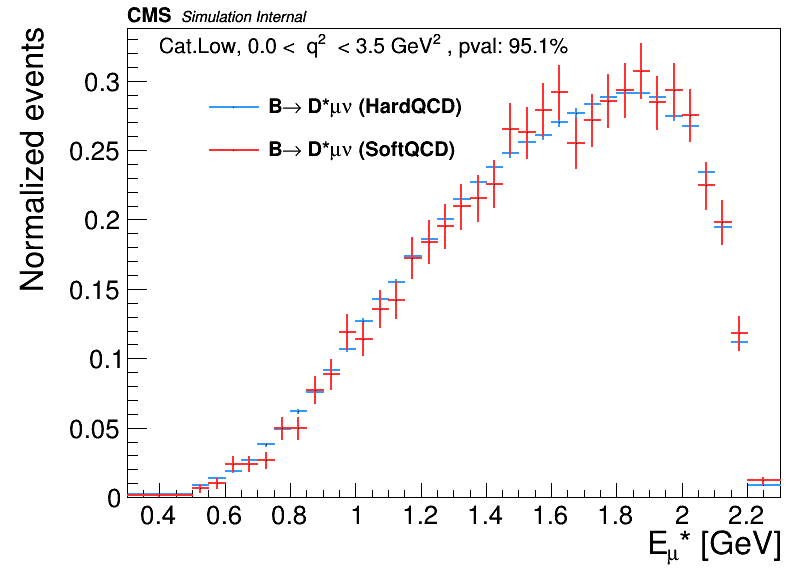

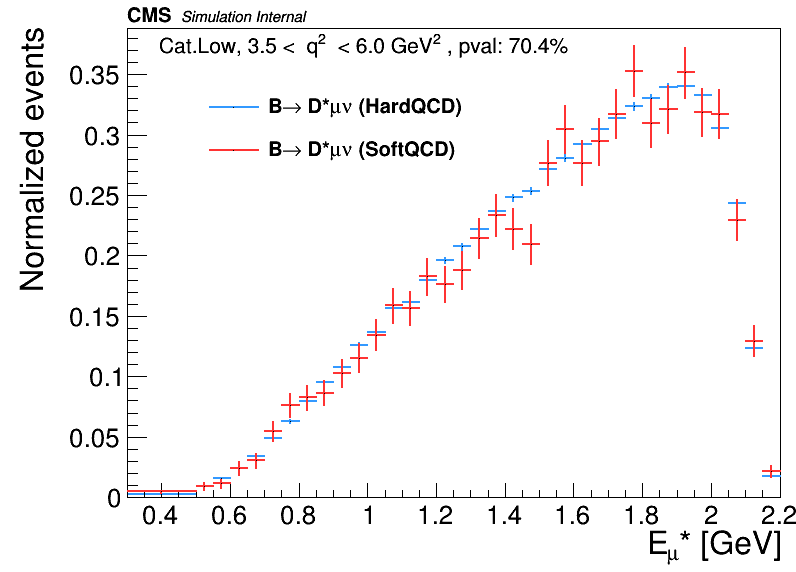

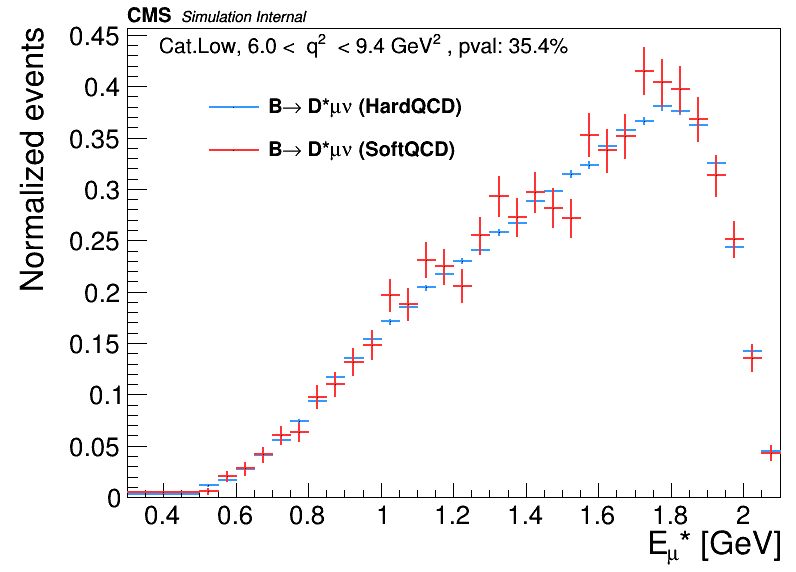

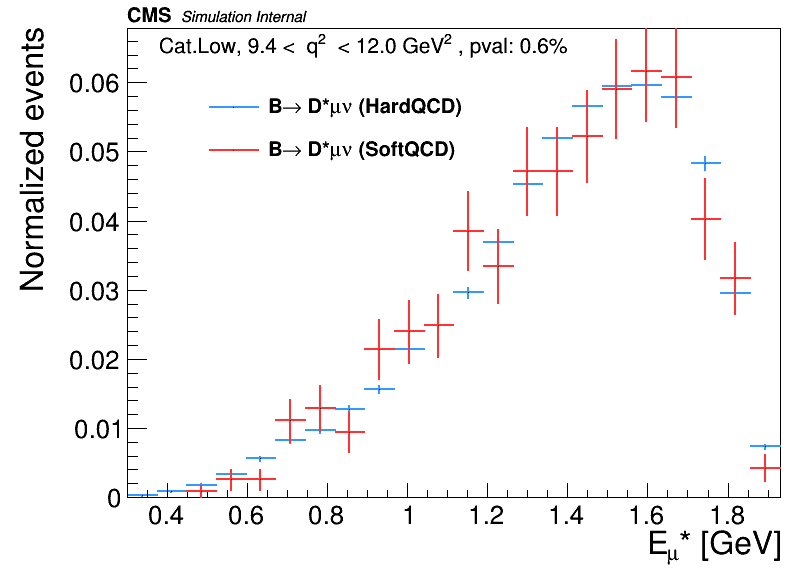

In [172]:
canvasOut = []
for var in ['M2_miss', 'Est_mu']:
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)
        selSoft = np.logical_and(dsSoft['q2'] > q2_l, dsSoft['q2'] <= q2_h)
        selHard = np.logical_and(dsHard['q2'] > q2_l, dsHard['q2'] <= q2_h)

        c = make_comp_plot_1D(
            [
                [dsHard[var][selHard], 'B#rightarrow D*#mu#nu (HardQCD)'],
                [dsSoft[var][selSoft], 'B#rightarrow D*#mu#nu (SoftQCD)'],
            ],
            scale_histo = [1./selHard.shape[0], 1./selSoft.shape[0]],
            binning=binning[var][i_q2], 
            setLog='', miny=1e-6,
            axis_title = [xAx_title.get(var, var), 'Normalized events'],
            leg_loc=[0.25, 0.7, 0.35, 0.15],
            tag=category +'_'+ var+'_q2bin'+str(i_q2)
        )
        
#         hH, _ = np.histogram(dsHard[var][selHard], binning[var][i_q2])
#         hS, _ = np.histogram(dsSoft[var][selSoft], binning[var][i_q2])
        
#         nH = float(np.sum(hH))
#         nS = float(np.sum(hS))
        
#         chi2 = 0
#         for i in range(hH.shape[0]):
#             pH = hH[i]/nH
#             sH = np.sqrt(nH*pH*(1-pH))
#             eS = nH*hS[i]/nS
#             print hH[i], hS[i], eS, pH, sH
#             print (eS - hH[i])/sH
#             chi2 += np.square((eS - hH[i])/sH)
#         print chi2
#         pval_me = sps.chi2.sf(chi2, hH.shape[0])
        
          
        hH, hS = c.dnd[0]
        pval_norm = hS.Chi2Test(hH, 'NORM')
        
        chi2 = 0
        for i in range(1, hH.GetNbinsX()):
            aux = hH.GetBinContent(i) - hS.GetBinContent(i)
            eS = hS.GetBinError(i)
            if eS == 0:
                eS = 2./selSoft.shape[0]
            aux /= np.hypot(hH.GetBinError(i), eS)
            chi2 += np.square(aux)
        pval_me = sps.chi2.sf(chi2, hH.GetNbinsX())

        s = 'Cat.' + category.capitalize() + ', ' + q2_txt
        s += ' , pval: {:.1f}%'.format(100*pval_me)
        txt.DrawLatexNDC(0.2, 0.92, s)
            

        c.SaveAs(webDir + category + '_' + var + '_q2bin'+str(i_q2) + '.png')
        canvasOut.append(c)